# 0. Import Libraries and Read source data

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score, average_precision_score,
    accuracy_score, confusion_matrix, classification_report, precision_recall_curve, make_scorer
)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform,loguniform
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
samples = pd.read_csv('./application_samples.csv')

In [3]:
features = pd.read_csv('./credit_features.csv')

In [4]:
data_dict = pd.read_csv('./data_dictionary.csv')

# 1. EDA

In [5]:
data_dict

Name  \
0                                    UID   
1                       Application Date   
2                                 Amount   
3                                   Term   
4                        Employment Type   
5                            LoanPurpose   
6                                Success   
7                 ALL_AgeOfOldestAccount   
8               ALL_AgeOfYoungestAccount   
9                              ALL_Count   
10                       ALL_CountActive   
11           ALL_CountClosedLast12Months   
12              ALL_CountDefaultAccounts   
13           ALL_CountOpenedLast12Months   
14                      ALL_CountSettled   
15                    ALL_MeanAccountAge   
16          ALL_SumCurrentOutstandingBal   
17    ALL_SumCurrentOutstandingBalExcMtg   
18        ALL_TimeSinceMostRecentDefault   
19  ALL_WorstPaymentStatusActiveAccounts   

                                          Description  
0                                   unique identifier  
1                            Date of loan application  
2                       Amount requested by applicant  
3             Repayment period requested by applicant  
4                                   Stated employment  
5                                     Purpose of loan  
6                                Applicant successful  
7                              Age of oldest accounts  
8                            Age of youngest accounts  
9                                     No. of accounts  
10                             No. of active accounts  
11            Count of accounts closed last 12 months  
12                          Count of default accounts  
13            Count of accounts opened last 12 months  
14                            No. of settled accounts  
15                                   Mean account age  
16                             Sum of outstanding Bal  
17  Sum of outstanding Bal excluding mortgage acco...  
18       Months since most recent default on accounts  
19                       Current Worst Payment Status

In [6]:
samples.head()

UID ApplicationDate  Amount  Term        EmploymentType  \
0  4921736      03/07/2020    2000    60  Employed - full time   
1  1241981      04/02/2020    3000    60  Employed - full time   
2  5751748      02/08/2020   20000    60  Employed - full time   
3  7163425      23/09/2020   20000    60         Self employed   
4   227377      01/01/2020    5000    36  Employed - full time   

              LoanPurpose  Success  
0        Unexpected bills        0  
1  Starting new bussniess        0  
2        Business capital        0  
3    New business venture        0  
4                     car        0

In [7]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UID              8847 non-null   int64 
 1   ApplicationDate  8847 non-null   object
 2   Amount           8847 non-null   int64 
 3   Term             8847 non-null   int64 
 4   EmploymentType   8847 non-null   object
 5   LoanPurpose      8847 non-null   object
 6   Success          8847 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 483.9+ KB


In [8]:
samples['UID'].nunique()

8847

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ALL_AgeOfOldestAccount                8847 non-null   int64  
 2   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 3   ALL_Count                             8847 non-null   int64  
 4   ALL_CountActive                       8847 non-null   int64  
 5   ALL_CountClosedLast12Months           8847 non-null   int64  
 6   ALL_CountDefaultAccounts              8847 non-null   int64  
 7   ALL_CountOpenedLast12Months           8847 non-null   int64  
 8   ALL_CountSettled                      8847 non-null   int64  
 9   ALL_MeanAccountAge                    8847 non-null   float64
 10  ALL_SumCurrentOutstandingBal          8847 non-null   int64  
 11  ALL_SumCurrentOut

In [ ]:
# Dropping this column as it contains a single unique value and adds no predictive value to the model.
print(features['ALL_TimeSinceMostRecentDefault'].nunique())
features = features.drop(columns=['ALL_TimeSinceMostRecentDefault'])

1


In [11]:
features.describe()

UID  ALL_AgeOfOldestAccount  ALL_AgeOfYoungestAccount  \
count  8.847000e+03             8847.000000               8847.000000   
mean   4.753101e+06              162.694021                  8.587431   
std    2.766232e+06               94.569878                 13.081866   
min    2.160090e+05               -1.000000                 -1.000000   
25%    2.376933e+06              100.000000                  2.000000   
50%    4.463541e+06              151.000000                  5.000000   
75%    7.194733e+06              212.000000                 10.000000   
max    9.684478e+06              999.000000                258.000000   

         ALL_Count  ALL_CountActive  ALL_CountClosedLast12Months  \
count  8847.000000      8847.000000                  8847.000000   
mean     17.515316         9.258506                     1.589691   
std      13.900171         4.896900                     2.611921   
min       0.000000        -1.000000                    -1.000000   
25%       9.000000         6.000000                     0.000000   
50%      15.000000         9.000000                     1.000000   
75%      22.000000        12.000000                     2.000000   
max     233.000000        43.000000                    60.000000   

       ALL_CountDefaultAccounts  ALL_CountOpenedLast12Months  \
count               8847.000000                  8847.000000   
mean                   1.380355                     2.453487   
std                    2.749450                     2.964837   
min                   -1.000000                    -1.000000   
25%                    0.000000                     1.000000   
50%                    0.000000                     2.000000   
75%                    2.000000                     3.000000   
max                   23.000000                    62.000000   

       ALL_CountSettled  ALL_MeanAccountAge  ALL_SumCurrentOutstandingBal  \
count       8847.000000         8847.000000                  8.847000e+03   
mean           8.231491           57.285159                  5.416258e+04   
std           11.419963           29.132180                  1.074432e+05   
min           -1.000000           -1.000000                 -1.000000e+00   
25%            2.000000           38.770000                  3.396000e+03   
50%            5.000000           53.120000                  1.267000e+04   
75%           10.000000           71.530000                  6.171250e+04   
max          215.000000          304.000000                  4.004808e+06   

       ALL_SumCurrentOutstandingBalExcMtg  \
count                         8847.000000   
mean                         12858.636148   
std                          17756.568825   
min                             -1.000000   
25%                           2438.000000   
50%                           8336.000000   
75%                          17990.500000   
max                         581415.000000   

       ALL_WorstPaymentStatusActiveAccounts  
count                           8847.000000  
mean                               2.057647  
std                                3.139938  
min                               -1.000000  
25%                                0.000000  
50%                                0.000000  
75%                                7.000000  
max                                7.000000

In [12]:
features['ALL_WorstPaymentStatusActiveAccounts'].nunique()

9

## 1-1. Generate Full_df merging application_samples & features

In [5]:
full_df = pd.merge(samples, features, on = 'UID')

In [6]:
full_df.head()

UID ApplicationDate  Amount  Term        EmploymentType  \
0  4921736      03/07/2020    2000    60  Employed - full time   
1  1241981      04/02/2020    3000    60  Employed - full time   
2  5751748      02/08/2020   20000    60  Employed - full time   
3  7163425      23/09/2020   20000    60         Self employed   
4   227377      01/01/2020    5000    36  Employed - full time   

              LoanPurpose  Success  ALL_AgeOfOldestAccount  \
0        Unexpected bills        0                     162   
1  Starting new bussniess        0                     266   
2        Business capital        0                      90   
3    New business venture        0                     163   
4                     car        0                     129   

   ALL_AgeOfYoungestAccount  ALL_Count  ALL_CountActive  \
0                        17         18               12   
1                        30         14               10   
2                        52          4                2   
3                        19         14                6   
4                         2         38               19   

   ALL_CountClosedLast12Months  ALL_CountDefaultAccounts  \
0                            0                         0   
1                            0                         4   
2                            0                         1   
3                            1                         1   
4                            4                         9   

   ALL_CountOpenedLast12Months  ALL_CountSettled  ALL_MeanAccountAge  \
0                            0                 6               70.94   
1                            0                 4              104.79   
2                            0                 2               68.25   
3                            0                 8               67.50   
4                            8                19               56.45   

   ALL_SumCurrentOutstandingBal  ALL_SumCurrentOutstandingBalExcMtg  \
0                         68555                               15019   
1                          2209                                2209   
2                          5108                                5108   
3                         25738                               25738   
4                          5801                                5801   

   ALL_TimeSinceMostRecentDefault  ALL_WorstPaymentStatusActiveAccounts  
0                              -1                                     0  
1                              -1                                     7  
2                              -1                                     7  
3                              -1                                     0  
4                              -1                                     7

In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 0 to 8846
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ApplicationDate                       8847 non-null   object 
 2   Amount                                8847 non-null   int64  
 3   Term                                  8847 non-null   int64  
 4   EmploymentType                        8847 non-null   object 
 5   LoanPurpose                           8847 non-null   object 
 6   Success                               8847 non-null   int64  
 7   ALL_AgeOfOldestAccount                8847 non-null   int64  
 8   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 9   ALL_Count                             8847 non-null   int64  
 10  ALL_CountActive                       8847 non-null   int64  
 11  ALL_CountClosedLa

In [ ]:
# Confirmed that there are no NaN value in the dataframe.
full_df.isna().sum()

UID                                     0
ApplicationDate                         0
Amount                                  0
Term                                    0
EmploymentType                          0
LoanPurpose                             0
Success                                 0
ALL_AgeOfOldestAccount                  0
ALL_AgeOfYoungestAccount                0
ALL_Count                               0
ALL_CountActive                         0
ALL_CountClosedLast12Months             0
ALL_CountDefaultAccounts                0
ALL_CountOpenedLast12Months             0
ALL_CountSettled                        0
ALL_MeanAccountAge                      0
ALL_SumCurrentOutstandingBal            0
ALL_SumCurrentOutstandingBalExcMtg      0
ALL_WorstPaymentStatusActiveAccounts    0
dtype: int64

# 2. Preprocessing - Feature Engineering

## Preprocessing Object Types
The columns `ApplicationDate`, `EmploymentType`, and `LoanPurpose` need preprocessing, as their current object types are unsuitable for machine learning inputs.

- **ApplicationDate**: Convert to datetime format, then extract year, day of the week, and calculate the number of days since the application date. For **month** and **day**, use **sine and cosine encoding** to capture their cyclical nature. Unlike one-hot encoding, which increases dimensionality, sine and cosine encoding preserves the cyclical relationship by mapping these features onto a circular plane. This approach allows the model to understand the cyclic order, such as how December and January are close in the cycle, without implying a linear ranking.
- **EmploymentType**: Apply one-hot encoding, which is suitable given the limited number of unique categories.
- **LoanPurpose**: Contains over 2,000 unique values.

### 1. ['ApplicationDate]

In [8]:
# Assuming `ApplicationDate` is in the 'DD/MM/YYYY' format
full_df['ApplicationDate'] = pd.to_datetime(full_df['ApplicationDate'], format='%d/%m/%Y')

In [9]:
# Extracting year, month, and day as separate columns
# we don't need year since it's just all 2020
# samples['ApplicationYear'] = samples['ApplicationDate'].dt.year
full_df['ApplicationMonth'] = full_df['ApplicationDate'].dt.month
full_df['ApplicationDay'] = full_df['ApplicationDate'].dt.day

# Extracting the day of the week (0=Monday, 6=Sunday)
full_df['ApplicationDayOfWeek'] = full_df['ApplicationDate'].dt.dayofweek

# Calculate the number of days since the application date
current_date = datetime.now()
full_df['DaysSinceApplication'] = (current_date - full_df['ApplicationDate']).dt.days

In [10]:
# Sine and cosine encoding for ApplicationMonth (1 to 12)
full_df['ApplicationMonth_sin'] = np.sin(2 * np.pi * full_df['ApplicationMonth'] / 12)
full_df['ApplicationMonth_cos'] = np.cos(2 * np.pi * full_df['ApplicationMonth'] / 12)

# Sine and cosine encoding for ApplicationDay (1 to 31)
full_df['ApplicationDay_sin'] = np.sin(2 * np.pi * full_df['ApplicationDay'] / 31)
full_df['ApplicationDay_cos'] = np.cos(2 * np.pi * full_df['ApplicationDay'] / 31)

# Sine and cosine encoding for ApplicationDayOfWeek (1 to 7)
full_df['ApplicationDayOfWeek_sin'] = np.sin(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)
full_df['ApplicationDayOfWeek_cos'] = np.cos(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)

In [11]:
full_df.drop(columns=['ApplicationDate','ApplicationMonth','ApplicationDay','ApplicationDayOfWeek'], inplace= True)

### 2. ['EmploymentType]

In [12]:
full_df['EmploymentType'].value_counts()

Employed - full time    7714
Employed - part time     570
Self employed            418
Retired                  145
Name: EmploymentType, dtype: int64

In [13]:
# Apply get_dummies to the 'EmploymentType' column only, then concatenate with the rest of the DataFrame.
employment_type_dummies = pd.get_dummies(full_df['EmploymentType'], prefix='EmploymentType').astype(int)

In [14]:
employment_type_dummies

EmploymentType_Employed - full time  \
0                                       1   
1                                       1   
2                                       1   
3                                       0   
4                                       1   
...                                   ...   
8842                                    1   
8843                                    1   
8844                                    1   
8845                                    0   
8846                                    1   

      EmploymentType_Employed - part time  EmploymentType_Retired  \
0                                       0                       0   
1                                       0                       0   
2                                       0                       0   
3                                       0                       0   
4                                       0                       0   
...                                   ...                     ...   
8842                                    0                       0   
8843                                    0                       0   
8844                                    0                       0   
8845                                    0                       0   
8846                                    0                       0   

      EmploymentType_Self employed  
0                                0  
1                                0  
2                                0  
3                                1  
4                                0  
...                            ...  
8842                             0  
8843                             0  
8844                             0  
8845                             1  
8846                             0  

[8847 rows x 4 columns]

In [15]:
# Drop the original 'EmploymentType' column from full_df
full_df = full_df.drop(columns=['EmploymentType'])

# Concatenate the dummy variables with the original DataFrame
full_df = pd.concat([full_df, employment_type_dummies], axis=1)

# Now, only the dummy columns have integer type, and the rest of the DataFrame retains its original types.
full_df.head()

UID  Amount  Term             LoanPurpose  Success  \
0  4921736    2000    60        Unexpected bills        0   
1  1241981    3000    60  Starting new bussniess        0   
2  5751748   20000    60        Business capital        0   
3  7163425   20000    60    New business venture        0   
4   227377    5000    36                     car        0   

   ALL_AgeOfOldestAccount  ALL_AgeOfYoungestAccount  ALL_Count  \
0                     162                        17         18   
1                     266                        30         14   
2                      90                        52          4   
3                     163                        19         14   
4                     129                         2         38   

   ALL_CountActive  ALL_CountClosedLast12Months  ...  ApplicationMonth_sin  \
0               12                            0  ...             -0.500000   
1               10                            0  ...              0.866025   
2                2                            0  ...             -0.866025   
3                6                            1  ...             -1.000000   
4               19                            4  ...              0.500000   

   ApplicationMonth_cos  ApplicationDay_sin  ApplicationDay_cos  \
0         -8.660254e-01            0.571268            0.820763   
1          5.000000e-01            0.724793            0.688967   
2         -5.000000e-01            0.394356            0.918958   
3         -1.836970e-16           -0.998717           -0.050649   
4          8.660254e-01            0.201299            0.979530   

   ApplicationDayOfWeek_sin  ApplicationDayOfWeek_cos  \
0                 -0.433884                 -0.900969   
1                  0.781831                  0.623490   
2                 -0.781831                  0.623490   
3                  0.974928                 -0.222521   
4                  0.974928                 -0.222521   

   EmploymentType_Employed - full time  EmploymentType_Employed - part time  \
0                                    1                                    0   
1                                    1                                    0   
2                                    1                                    0   
3                                    0                                    0   
4                                    1                                    0   

   EmploymentType_Retired  EmploymentType_Self employed  
0                       0                             0  
1                       0                             0  
2                       0                             0  
3                       0                             1  
4                       0                             0  

[5 rows x 29 columns]

### 3. 'LoanPurpose'

In [16]:
# We have more than 2,000 unique values of Loan Purpose, we need to categorize them.
full_df['LoanPurpose'].nunique()

2444

In [17]:
full_df['LoanPurpose'].value_counts()[:30]

Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
Home improvement      224
Home improvements     221
consolidation         137
debt consolidation    133
home improvements     113
Debt Consolidation    103
New car                90
home improvement       86
Furniture              78
Home Improvments       67
Short Term Loan        65
Debt                   64
other                  59
Car repairs            50
Home Improvements      50
Car purchase           49
Debts                  49
new car                41
Car repair             40
Home Improvement       38
furniture              36
Wedding                36
Home                   33
Car loan               33
Vets bills             32
Name: LoanPurpose, dtype: int64

In [18]:
# first of all, make all entries lowercase since there are variations like "car" and "Car," "home" and "Home"...
full_df['LoanPurpose'] = full_df['LoanPurpose'].str.lower()

#### applied tf-idf vectorization, but clustering results were unsatisfactory

In [29]:
df = full_df.copy()

In [30]:
# # TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))  # 2-grams
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])

## Vectorization and Clustering
number_of_cluster = 5
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])
kmeans = KMeans(n_clusters=number_of_cluster, random_state=42)
df['LoanPurposeCluster'] = kmeans.fit_predict(X_tfidf)

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
# Get feature names from TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()
# terms = vectorizer.get_feature_names_out()

# Display top terms for each cluster
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {i} top terms:")
    term_indices = np.argsort(center)[-10:]  # Get indices of top 10 terms
    top_terms = [terms[ind] for ind in term_indices]
    print(top_terms)


Cluster 0 top terms:
['house', 'loan', 'new car', 'furniture', 'new', 'debts', 'car', 'home improvements', 'home', 'improvements']

Cluster 1 top terms:
['decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decking', 'çar tax insurance', 'home', 'improvement', 'home improvement']

Cluster 2 top terms:
['decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decor', 'çar tax insurance', 'consolidation', 'debt consolidation', 'debt']

Cluster 3 top terms:
['decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decoration', 'dekory', 'çar tax insurance', 'car']

Cluster 4 top terms:
['decorated', 'decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decking garden', 'çar tax insurance', 'consolidation']


#### applied sentence transformer ('paraphrase-MiniLM-L6-v2') for embedding-based clustering, leveraging the model’s pre-trained understanding of word meanings for improved performance; this approach produced notably better clustering results compared to tf-idf.

In [ ]:
# Generation of Embedding of Sentence-BERT model
transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
loan_purpose_embeddings = transformer_model.encode(full_df['LoanPurpose'])

In [36]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
full_df['LoanPurposeCluster'] = kmeans.fit_predict(loan_purpose_embeddings)

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
# Display sample texts from each cluster

num_clusters = full_df['LoanPurposeCluster'].nunique()
for cluster in range(num_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = full_df[full_df['LoanPurposeCluster'] == cluster]['LoanPurpose'].sample(20, random_state=42)
    for text in cluster_texts:
        print(f"- {text}")


Cluster 0:
- house hold goods
- tools
- personal loan
- credit cards
- other
- other
- consilodation
- to buy a wheelchair
- short break
- paying off credit card
- pay off credit cards
- holidays
- baby costs
- vets bills
- clearing credit cards
- dentist
- debt/household goods
- engagement ring
- spending money
- flooring

Cluster 1:
- home improvemnts
- home improvements
- decorate my house
- home improvments
- house improvements
- furniture
- household
- home improvement
- home improvements
- home  improvement
- home improvement
- home improvements
- home improvements
- building work
- home improvments
- home improvements
- home improvement
- pay bills and home improvements
- home improvement
- home improvement

Cluster 2:
- debt consolidation
- debts
- consolidating bills
- consolidate debt
- consolidate bills
- debt consolidation
- consolidating all debts
- consolidation
- debt
- consolidation and car
- consolidation
- consolidation of credit
- consolidation
- debt consolidation


* Cluster 0: General Expenses & Miscellaneous  
This cluster includes diverse spending categories, such as household goods, personal loans, credit card payments, holidays, medical expenses, and debt repayment. The variety suggests general or miscellaneous expenses.

* Cluster 1: Home Improvement  
The cluster is dominated by terms related to home upgrades and repairs, such as “home improvement,” “decorate my house,” and “building work.”
* Cluster 2: Debt Consolidation  
Most entries refer to debt-related terms, particularly debt consolidation, bill consolidation, and repayment.
* Cluster 3: Vehicle Expenses  
This cluster is centered around car-related expenses, including car purchases, loans, repairs, and payments.

In [ ]:
# One-hot encode the LoanPurposeCluster column
full_df = pd.get_dummies(full_df, columns=['LoanPurposeCluster'], prefix='LoanPurpose')

# Convert only the one-hot encoded columns to integer type.
for column in full_df.columns:
    if column.startswith('LoanPurpose_'):
        full_df[column] = full_df[column].astype(int)

In [40]:
# Now we don't need the actual LoanPurpose column, because we just categorized them.
full_df.drop(columns = ['LoanPurpose'], inplace = True)

In [41]:
full_df

UID  Amount  Term  Success  ALL_AgeOfOldestAccount  \
0     4921736    2000    60        0                     162   
1     1241981    3000    60        0                     266   
2     5751748   20000    60        0                      90   
3     7163425   20000    60        0                     163   
4      227377    5000    36        0                     129   
...       ...     ...   ...      ...                     ...   
8842  8681053    5000    60        0                     164   
8843  8768469    8000    24        0                     275   
8844  8794971    1000    36        0                     145   
8845  8875138   10000    60        0                      12   
8846  9134889   20000    60        0                      45   

      ALL_AgeOfYoungestAccount  ALL_Count  ALL_CountActive  \
0                           17         18               12   
1                           30         14               10   
2                           52          4                2   
3                           19         14                6   
4                            2         38               19   
...                        ...        ...              ...   
8842                         2         22               16   
8843                        20          7                4   
8844                         8         14               13   
8845                         7          4                3   
8846                        12          6                5   

      ALL_CountClosedLast12Months  ALL_CountDefaultAccounts  ...  \
0                               0                         0  ...   
1                               0                         4  ...   
2                               0                         1  ...   
3                               1                         1  ...   
4                               4                         9  ...   
...                           ...                       ...  ...   
8842                            2                         0  ...   
8843                            1                         1  ...   
8844                            0                         0  ...   
8845                            1                         0  ...   
8846                            1                         0  ...   

      ApplicationDayOfWeek_sin  ApplicationDayOfWeek_cos  \
0                    -0.433884                 -0.900969   
1                     0.781831                  0.623490   
2                    -0.781831                  0.623490   
3                     0.974928                 -0.222521   
4                     0.974928                 -0.222521   
...                        ...                       ...   
8842                  0.781831                  0.623490   
8843                 -0.433884                 -0.900969   
8844                 -0.781831                  0.623490   
8845                  0.781831                  0.623490   
8846                 -0.974928                 -0.222521   

      EmploymentType_Employed - full time  \
0                                       1   
1                                       1   
2                                       1   
3                                       0   
4                                       1   
...                                   ...   
8842                                    1   
8843                                    1   
8844                                    1   
8845                                    0   
8846                                    1   

      EmploymentType_Employed - part time  EmploymentType_Retired  \
0                                       0                       0   
1                                       0                       0   
2                                       0                       0   
3                                       0                       0   
4                                       0                       0   
...

In [42]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 0 to 8846
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   Amount                                8847 non-null   int64  
 2   Term                                  8847 non-null   int64  
 3   Success                               8847 non-null   int64  
 4   ALL_AgeOfOldestAccount                8847 non-null   int64  
 5   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 6   ALL_Count                             8847 non-null   int64  
 7   ALL_CountActive                       8847 non-null   int64  
 8   ALL_CountClosedLast12Months           8847 non-null   int64  
 9   ALL_CountDefaultAccounts              8847 non-null   int64  
 10  ALL_CountOpenedLast12Months           8847 non-null   int64  
 11  ALL_CountSettled 

In [ ]:
# Preprocess End

In [2]:
full_df = pd.read_csv('full_df.csv')

In [3]:
print("Before:", full_df.shape)

Before: (8847, 30)


In [4]:
# drop the rows with -1 value
full_df = full_df[(full_df != -1).all(axis=1)]

In [5]:
print("After:", full_df.shape)

After: (7335, 30)


# 3. Feature Selection - Using Techniques

In [6]:
full_df.drop(columns = ['UID'], inplace = True)

KeyError: "['UID'] not found in axis"

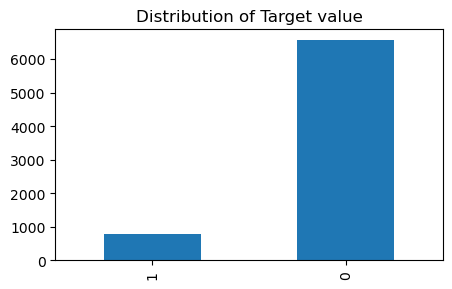

0    6555
1     780
Name: Success, dtype: int64

In [7]:
plt.figure(figsize = (5,3))
full_df.Success.value_counts().sort_values().plot(kind = 'bar')
plt.title('Distribution of Target value')
plt.show()
full_df.Success.value_counts()

The ratio of the minority class (1) is approximately 10.63% of the total dataset. ￼

## Apply SMOTE

In [18]:
# Define X and y
X = full_df.drop(columns=['Success'])
y = full_df['Success']

# Apply SMOTE
smote=SMOTE(sampling_strategy='minority') 
X, y = smote.fit_resample(X,y)

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle = True,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scale the data
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

0    6555
1    6555
Name: Success, dtype: int64

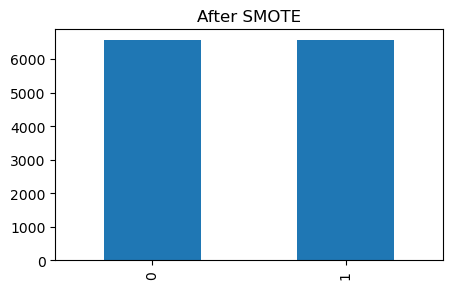

In [19]:
plt.figure(figsize = (5,3))
y.value_counts().plot(kind = 'bar', title = 'After SMOTE')
y.value_counts()

In [ ]:
# from imblearn.over_sampling import ADASYN

# # Applying ADASYN
# adasyn = ADASYN(sampling_strategy='minority')
# x_resampled, y_resampled = adasyn.fit_resample(X, y)
# # Count outcome values after applying ADASYN
# y_resampled.value_counts()

0    6555
1    6555
Name: Success, dtype: int64

## 3-0. Define Baseline Model

I have created the `ModelEvaluator` class for convenience. It is designed to evaluate machine learning models, tracking their performance metrics and visualizing results for comparison. It includes methods for calculating scores based on specific features and for plotting these results.

#### Key Methods

1. **`__init__`**: Initializes the class with an empty DataFrame (`graph_df`) to store model performance metrics (F1 Score and PR-AUC).

2. **`calculate_update_score`**: 
   - Takes a model, method name, and selected features as inputs. Optionally, it accepts manually specified training and testing data (`manual_X_train`, `manual_X_test`).
   - If manual features are provided, it uses those; otherwise, it uses the selected feature set from scaled training and test data (`X_train_scaled`, `X_test_scaled`).
   - Fits the model, makes predictions, and calculates the **F1 Score** and **PR-AUC**.
   - Prints the scores and appends them to `graph_df` for future plotting.

3. **`plot_scores`**:
   - Converts `graph_df` to a long format for easier plotting and dynamically adjusts the plot size based on the number of methods.
   - Plots the F1 Score and PR-AUC for each method using a bar chart, adding value labels on each bar for clarity.
   - Displays a comparison of model performance across different feature sets and methods.

In [44]:
class ModelEvaluator:
    def __init__(self):
        self.graph_df = pd.DataFrame(columns = ['Method', 'f1_score', 'pr_auc_score'])

    def calculate_update_score(self, model, method, selected_features, manual_X_train=None, manual_X_test=None):

        # if selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
        if isinstance(selected_features, str) and selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
            sel_X_train = manual_X_train
            sel_X_train = manual_X_train
            sel_X_test = manual_X_test
            num_features = manual_X_train.shape[1]
        else:
            sel_X_train = X_train_scaled[selected_features]
            sel_X_test = X_test_scaled[selected_features]
            num_features = len(selected_features)

        model.fit(sel_X_train, y_train)

        y_pred = model.predict(sel_X_test)
        y_probs = model.predict_proba(sel_X_test)[:, 1]

        f1 = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
        pr_auc = round(average_precision_score(y_test, y_probs), 3)

        print(f'{method}_n_features_{num_features}_f1_score :, {f1}')
        print(f'{method}_n_features_{num_features}_pr_auc_score : {pr_auc}')

        # Append results to the graph DataFrame
        new_row = pd.DataFrame([{
            'Method' : f'{method}_n_features_{num_features}',
            # 'Method' : f'{method}',
            'f1_score' : f1,
            'pr_auc_score' : pr_auc
        }],)
        self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)

    def plot_scores(self, title = None):
        graph_df_long = self.graph_df.melt(id_vars = 'Method', var_name = 'Metric', value_name = 'Score')

        # Dynamically adjust the figure width based on the number of methods
        fig_width = max(8, len(self.graph_df['Method'].unique()) * 2)  # Ensures a minimum width of 8
        plt.figure(figsize=(fig_width, 6))

        # Plot with seaborn
        ax = sns.barplot(x = 'Method', y = 'Score', hue = 'Metric', data = graph_df_long)
        if title :
            plt.title(title)
        else:
            plt.title('Comparison of F1 score and PR-AUC score by method')
        plt.ylabel('Score')
        plt.xlabel('Method')
        # plt.ylim(0,1)
        ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

        # Add values on top of each bar
        for container in ax.containers:
            ax.bar_label(container, fmt = '%.3f')

        plt.xticks(rotation = 45, ha = 'right')
        plt.tight_layout()
        plt.show()

In [45]:
evaluator = ModelEvaluator()

In [46]:
dt_clf = tree.DecisionTreeClassifier(random_state= 42, class_weight='balanced')
evaluator.calculate_update_score(dt_clf, method = 'DecisionTree', selected_features = X.columns)
# evaluator.plot_scores()

DecisionTree_n_features_29_f1_score :, 0.881
DecisionTree_n_features_29_pr_auc_score : 0.836


In [47]:
knn_clf = KNeighborsClassifier()
evaluator.calculate_update_score(knn_clf, method = 'KNN', selected_features = X.columns)
# evaluator.plot_scores()

KNN_n_features_29_f1_score :, 0.878
KNN_n_features_29_pr_auc_score : 0.951


In [48]:
lr_clf = LogisticRegression(solver = 'liblinear',random_state=42, class_weight='balanced')
evaluator.calculate_update_score(lr_clf, method = 'Logistic_Regression', selected_features = X.columns)
# evaluator.plot_scores()

Logistic_Regression_n_features_29_f1_score :, 0.875
Logistic_Regression_n_features_29_pr_auc_score : 0.961


In [49]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
evaluator.calculate_update_score(rf_clf, method = 'RF', selected_features = X.columns)
# evaluator.plot_scores()

RF_n_features_29_f1_score :, 0.945
RF_n_features_29_pr_auc_score : 0.988


In [50]:
gbm_clf = GradientBoostingClassifier(random_state=42)
evaluator.calculate_update_score(gbm_clf, method = 'GBM', selected_features = X.columns)
# evaluator.plot_scores()

GBM_n_features_29_f1_score :, 0.931
GBM_n_features_29_pr_auc_score : 0.984


In [51]:
xgb_clf = XGBClassifier(random_state=42)
evaluator.calculate_update_score(xgb_clf, method = 'XGB', selected_features = X.columns)
# evaluator.plot_scores()

XGB_n_features_29_f1_score :, 0.937
XGB_n_features_29_pr_auc_score : 0.987


In [52]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
evaluator.calculate_update_score(cb_clf, method = 'CatBoost', selected_features = X.columns)
# evaluator.plot_scores()

CatBoost_n_features_29_f1_score :, 0.937
CatBoost_n_features_29_pr_auc_score : 0.987


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_col_wise=true` to remove the overhead.
LGBM_n_features_29_f1_score :, 0.936
LGBM_n_features_29_pr_auc_score : 0.986


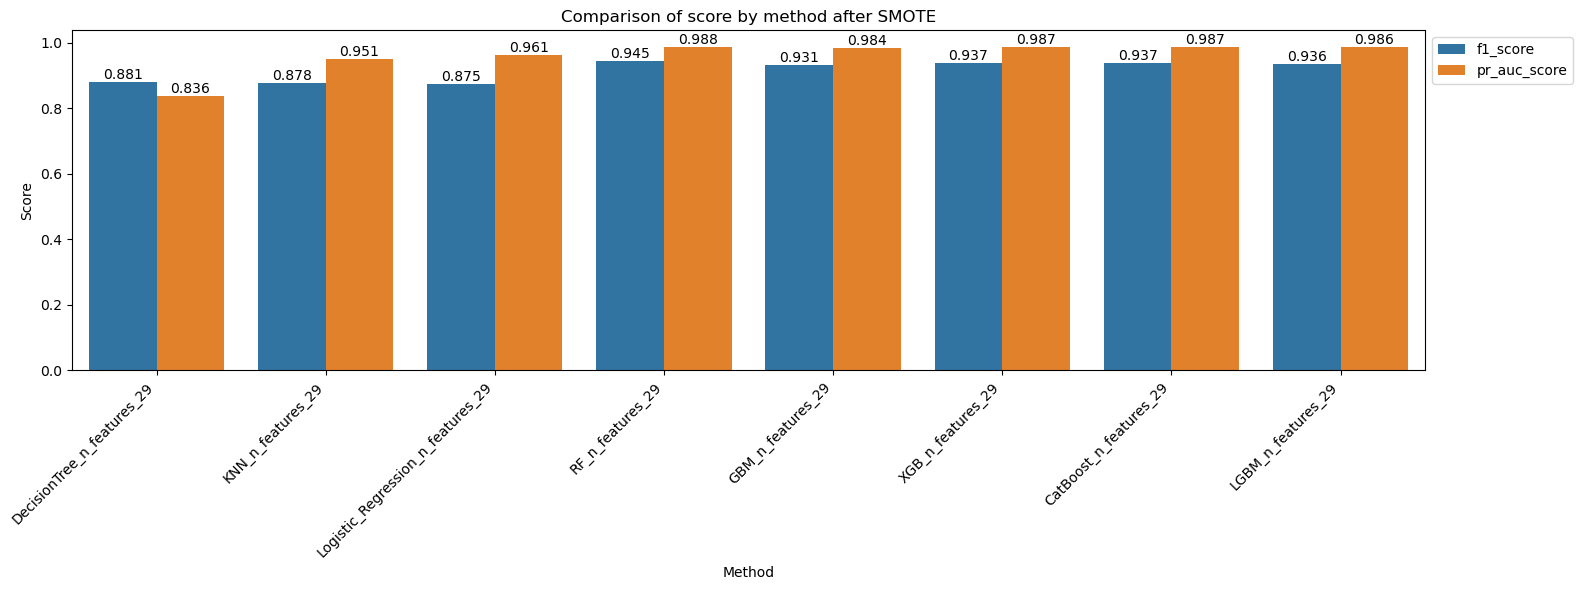

In [53]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0, class_weight='balanced')
evaluator.calculate_update_score(lgbm_clf, method = 'LGBM', selected_features = X.columns)
evaluator.plot_scores(title = 'Comparison of score by method after SMOTE')

    XGboost is selected as the baseline model due to its relatively high F1 and PR-AUC scores.

In [54]:
base_model = xgb_clf

## 3-1. Filter Methods -(1) Variance Threshold

In [55]:
scaler = MinMaxScaler()

X_train_scaled_minmax = scaler.fit_transform(X_train)

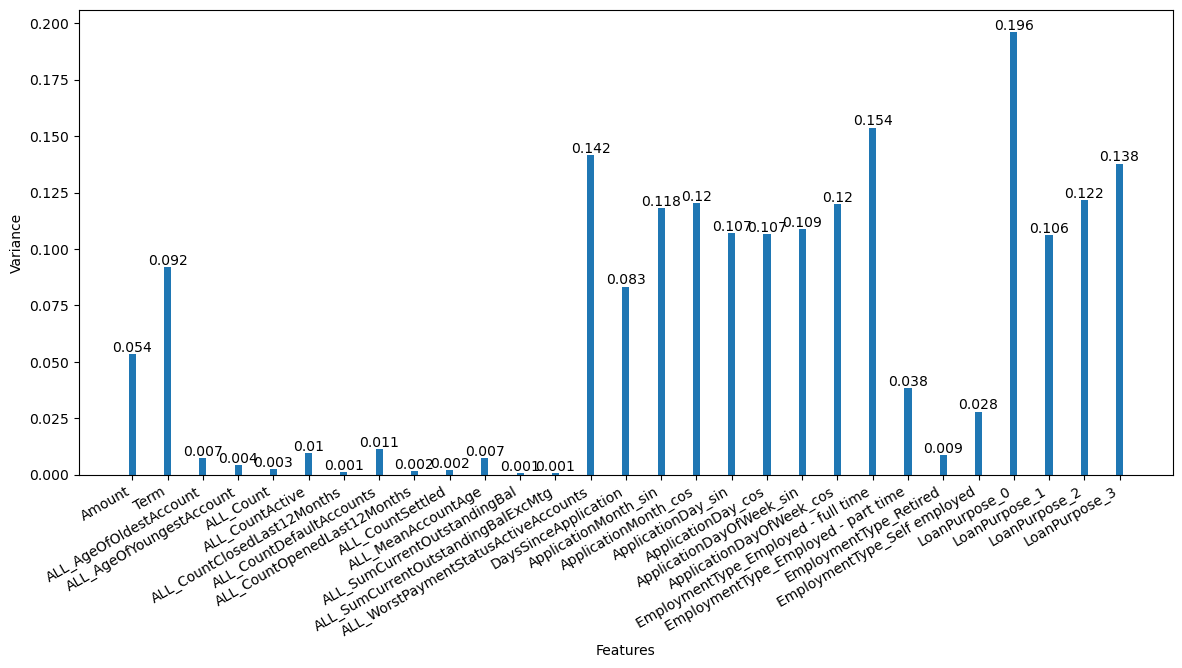

In [56]:
fig, ax = plt.subplots(figsize = (12,6))

x = X.columns
y = X_train_scaled_minmax.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
# ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [57]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.937
base_xgb_n_features_29_pr_auc_score : 0.987


In [63]:
# var_threshold = 0.05
var_threshold = 0.15
var_selected_cols = X.columns[[value > var_threshold for value in X_train_scaled_minmax.var(axis=0)]]
print(var_selected_cols)

Index(['EmploymentType_Employed - full time', 'LoanPurpose_0'], dtype='object')


Var_threshold_0.15_n_features_2_f1_score :, 0.596
Var_threshold_0.15_n_features_2_pr_auc_score : 0.597


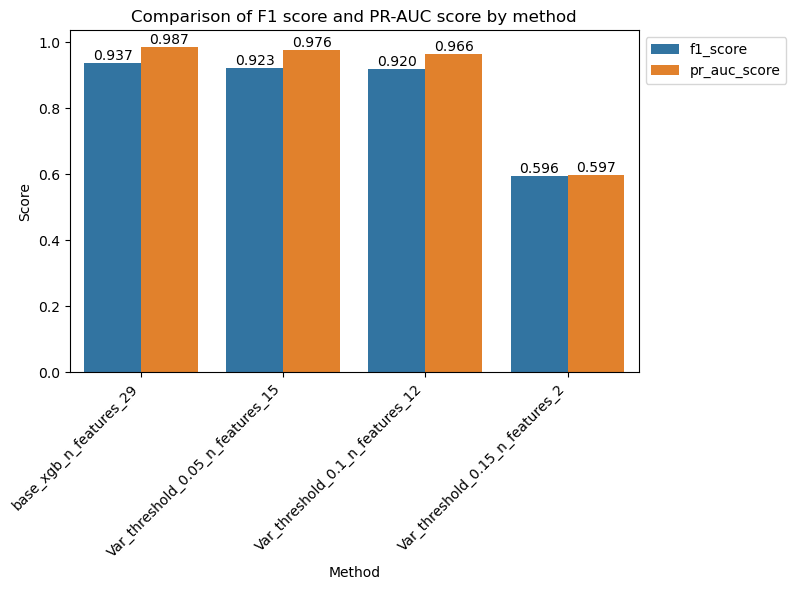

In [64]:
evaluator.calculate_update_score(base_model, method = f'Var_threshold_{var_threshold}', selected_features=var_selected_cols)
evaluator.plot_scores()

    After dropping some low-variance columns, the F1 and PR-AUC scores decreased, so let's try other methods.

## 3-1. Filter Methods - (2) Correlation

When the correlation between features exceeds 0.8, keep the one with a higher correlation to the target and drop the other. Then, keep only the top N features with the highest correlation to the target.

In [65]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)
# evaluator.plot_scores()

base_xgb_n_features_29_f1_score :, 0.937
base_xgb_n_features_29_pr_auc_score : 0.987


In [66]:
# Calculate the correlation matrix using Spearman
correlation_matrix = full_df.corr(method='spearman')

# Calculate correlation of each feature with the target
target_corr = full_df.corr()['Success'].abs().drop('Success')

# Identify pairs of features with high inter-correlation
correlation_threshold = 0.8
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# For each pair of highly correlated features, drop the one with the lower correlation to the target
to_drop = set()
for column in upper_triangle.columns:
    high_corr_features = upper_triangle.index[upper_triangle[column].abs() > correlation_threshold].tolist()
    for feature in high_corr_features:
        # Compare correlation with the target and keep the more correlated feature
        if target_corr[feature] > target_corr[column]:
            to_drop.add(column)
        else:
            to_drop.add(feature)

# Drop the selected features from X_train
print(to_drop)
X_reduced = X.drop(columns=to_drop)

{'ALL_CountDefaultAccounts', 'ALL_CountSettled', 'ALL_Count'}


In [67]:
# Select top features with the highest absolute correlation to the target
n = 15  # Number of top features to keep
corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()

print("Selected features:", corr_selected_cols)

Selected features: ['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_MeanAccountAge', 'ALL_CountOpenedLast12Months', 'ALL_CountActive', 'ALL_AgeOfOldestAccount', 'ALL_SumCurrentOutstandingBalExcMtg', 'DaysSinceApplication', 'ALL_CountClosedLast12Months', 'ALL_SumCurrentOutstandingBal', 'ApplicationMonth_sin', 'EmploymentType_Employed - part time', 'ApplicationDay_sin', 'EmploymentType_Self employed', 'LoanPurpose_2']


In [68]:
corr_selected_cols

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_AgeOfOldestAccount',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'DaysSinceApplication',
 'ALL_CountClosedLast12Months',
 'ALL_SumCurrentOutstandingBal',
 'ApplicationMonth_sin',
 'EmploymentType_Employed - part time',
 'ApplicationDay_sin',
 'EmploymentType_Self employed',
 'LoanPurpose_2']

- Corr_1 : For each pair of highly correlated features, drop the one with the lower correlation to the target only -> n_features = 25
- Corr_ : Corr_1 + chosse top N features in the order of highest absolute correlation to the target -> n_features = 10

In [69]:
evaluator.calculate_update_score(base_model, method = 'Corr_1', selected_features = X_reduced.columns)
# evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)
# evaluator.plot_scores()

Corr_1_n_features_26_f1_score :, 0.934
Corr_1_n_features_26_pr_auc_score : 0.986


In [70]:
def number_of_top_features(n):
    corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()
    evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)
    # evaluator.plot_scores()

for i in range(3,20,2):
    number_of_top_features(i)

Corr_n_features_3_f1_score :, 0.818
Corr_n_features_3_pr_auc_score : 0.913
Corr_n_features_5_f1_score :, 0.864
Corr_n_features_5_pr_auc_score : 0.939
Corr_n_features_7_f1_score :, 0.891
Corr_n_features_7_pr_auc_score : 0.958
Corr_n_features_9_f1_score :, 0.902
Corr_n_features_9_pr_auc_score : 0.965
Corr_n_features_11_f1_score :, 0.925
Corr_n_features_11_pr_auc_score : 0.984
Corr_n_features_13_f1_score :, 0.931
Corr_n_features_13_pr_auc_score : 0.985
Corr_n_features_15_f1_score :, 0.937
Corr_n_features_15_pr_auc_score : 0.986
Corr_n_features_17_f1_score :, 0.932
Corr_n_features_17_pr_auc_score : 0.985
Corr_n_features_19_f1_score :, 0.935
Corr_n_features_19_pr_auc_score : 0.985


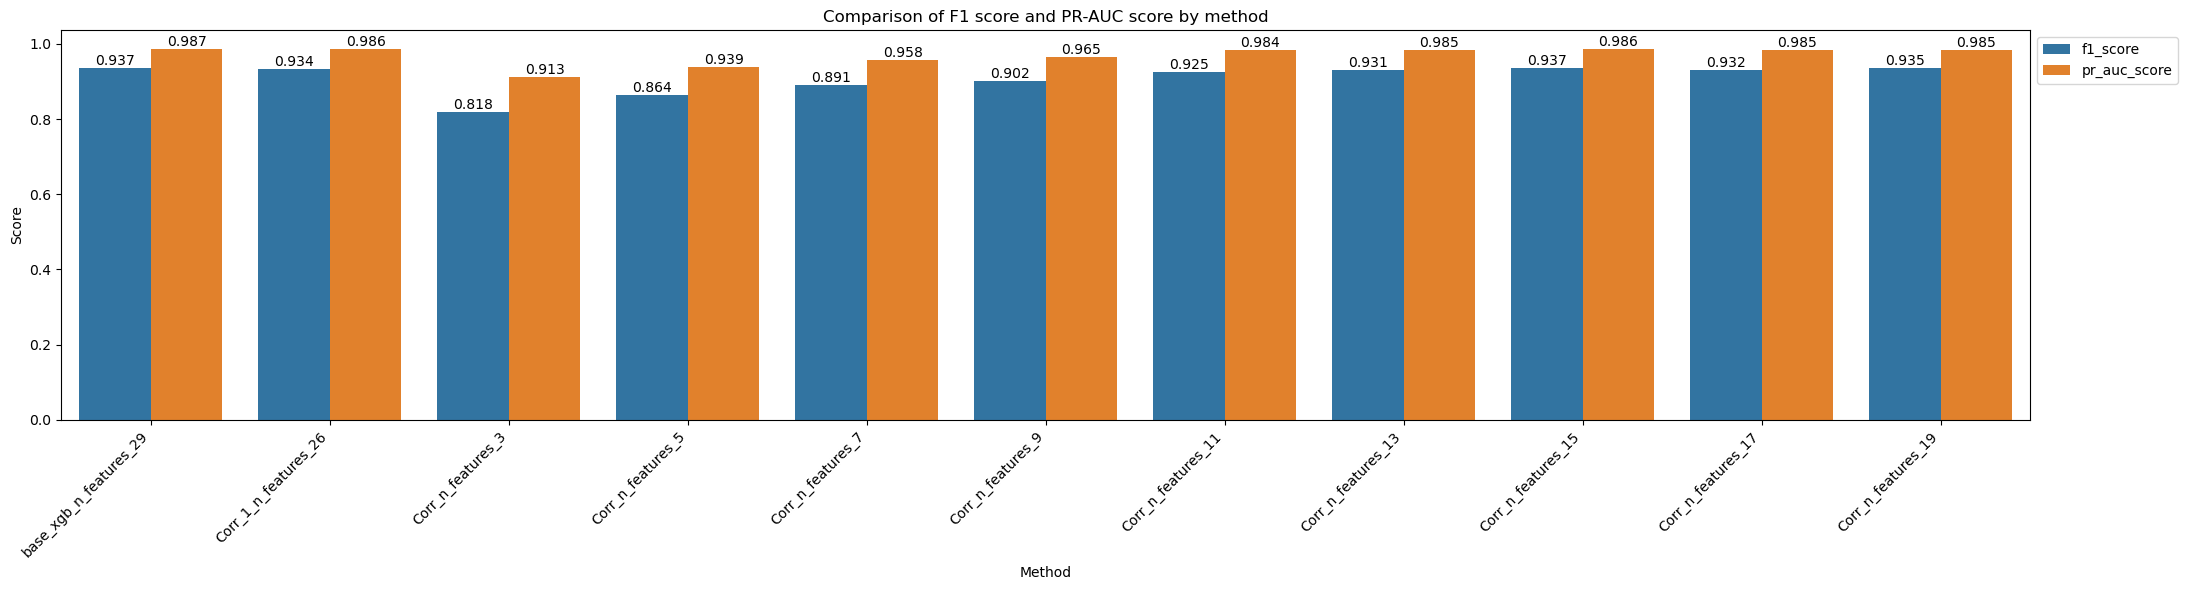

In [71]:
evaluator.plot_scores()

    I found that reducing the number of features to a very small set, like 5, leads to a low PR-AUC score. However, aside from this extreme case, the scores remain stable regardless of the number of features.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

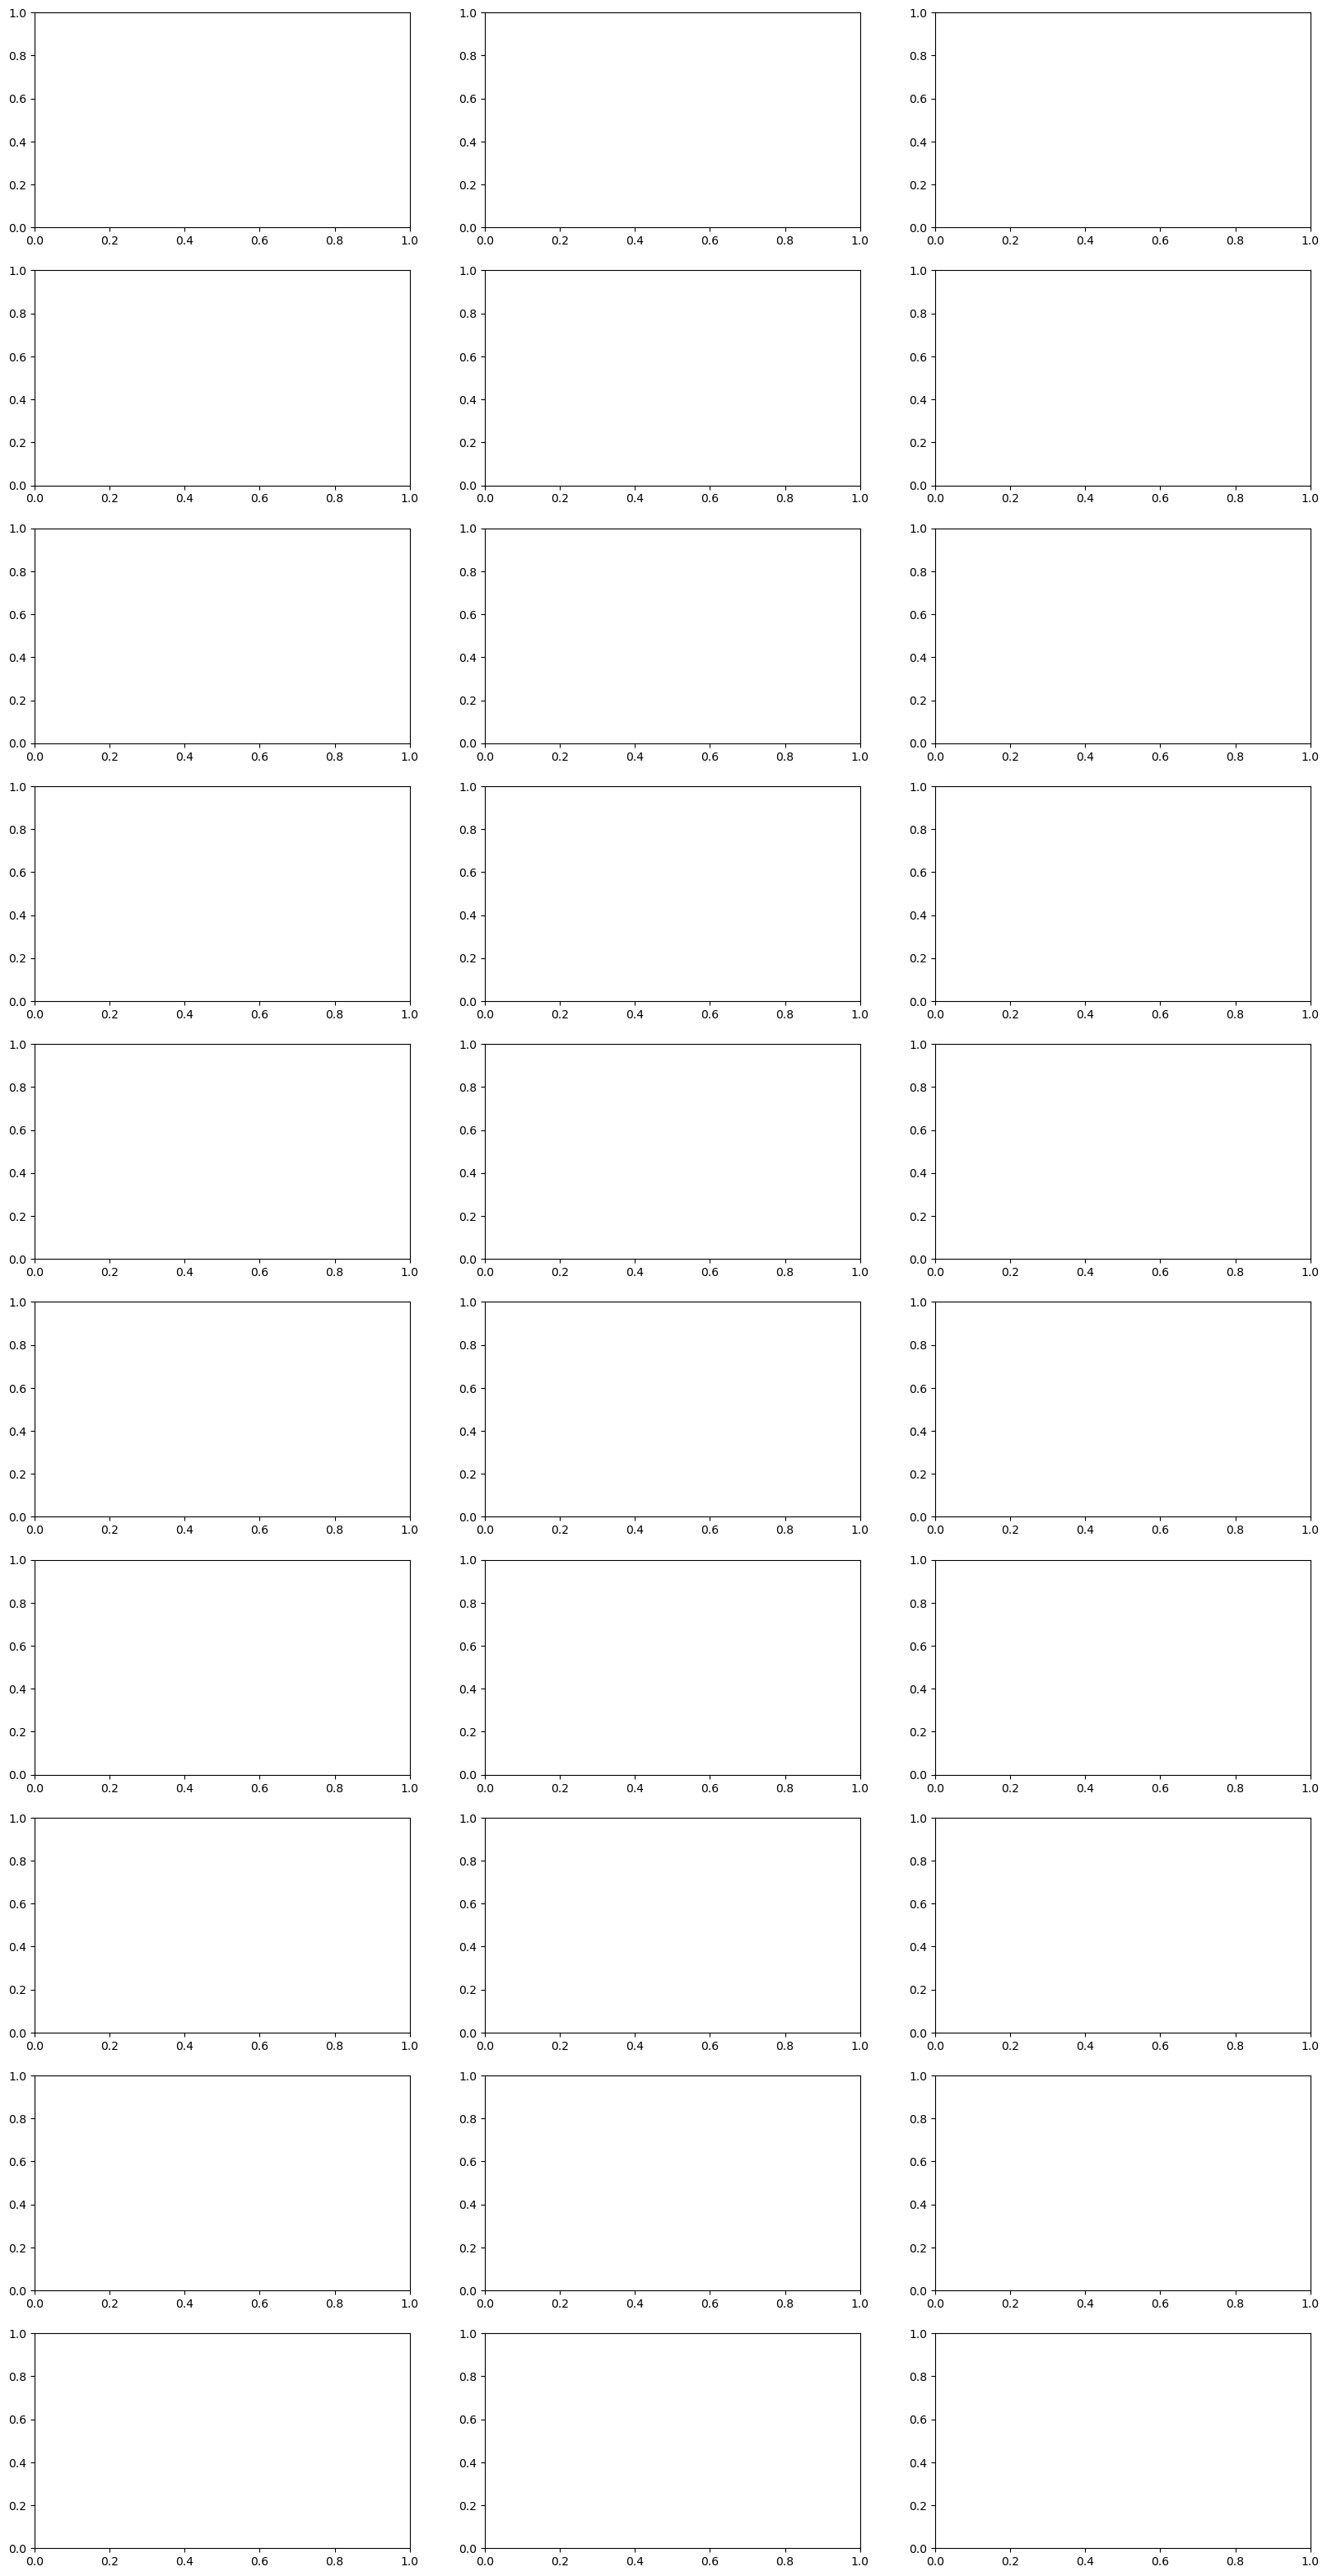

In [ ]:
num_features = full_df.select_dtypes(include=['float64', 'int64']).columns

num_plots = len(num_features)
ncols = 3
nrows = (num_plots // ncols) + (num_plots % ncols > 0)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, nrows * 4))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.histplot(data = full_df, x = feature, hue = 'Success', kde = True, ax = axes[i])
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Checked the correlation graph to see if any continuous variables had overlapping but slightly separated regions between 0 and 1, however, no significant findings were observed.

## 3-1. Filter Method - (3) Mutual Information

In [79]:
f1_score_list = []
pr_auc_score_list = []

In [80]:
len(X.columns)

29

In [81]:
for k in range(1, len(X.columns)+1):
    selector = SelectKBest(mutual_info_classif, k = k)
    selector.fit(X_train, y_train)

    kbest_X_train = selector.transform(X_train)
    kbest_X_test = selector.transform(X_test)

    base_model.fit(kbest_X_train, y_train)
    kbest_y_pred = base_model.predict(kbest_X_test)
    kbest_y_probs = base_model.predict_proba(kbest_X_test)[:, 1]

    kbest_f1_score = round(f1_score(y_test, kbest_y_pred, average = 'weighted'), 3)
    kbest_pr_auc_score = round(average_precision_score(y_test, kbest_y_probs), 3)

    f1_score_list.append(kbest_f1_score)
    pr_auc_score_list.append(kbest_pr_auc_score)


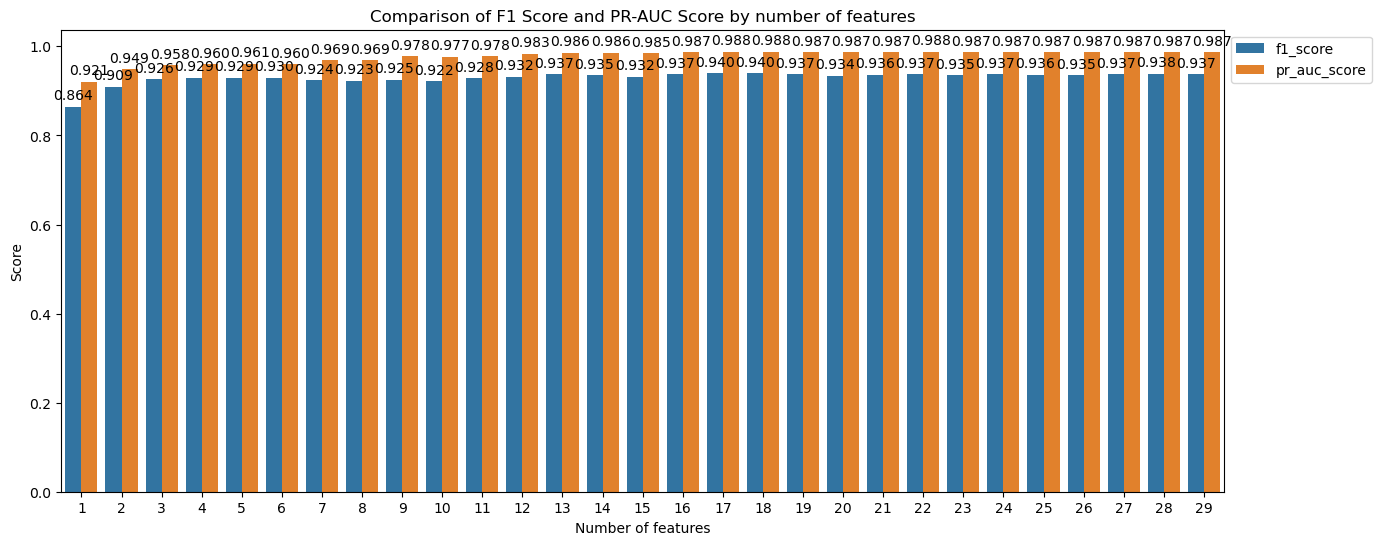

In [83]:
temp_df = pd.DataFrame({
    'number_features' : range(1,len(X.columns)+1),
    'f1_score' : f1_score_list,
    'pr_auc_score' : pr_auc_score_list
})

# Melt the DataFrame into long format
temp_df_long = temp_df.melt(id_vars='number_features', var_name='Metric', value_name='Score')

# Plot with Seaborn
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='number_features', y='Score', hue='Metric', data= temp_df_long)
plt.title('Comparison of F1 Score and PR-AUC Score by number of features')
plt.ylabel('Score')
plt.xlabel('Number of features')
# plt.ylim(0,1)
ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()

In [84]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.937
base_xgb_n_features_29_pr_auc_score : 0.987


In [89]:
selector = SelectKBest(mutual_info_classif, k =15)
selector.fit(X_train, y_train)

selected_feature_mask = selector.get_support()

mi_sel_features = X_train.columns[selected_feature_mask]

mi_sel_features

Index(['Amount', 'Term', 'ALL_CountActive', 'ALL_CountDefaultAccounts',
       'ALL_CountOpenedLast12Months', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_WorstPaymentStatusActiveAccounts',
       'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos',
       'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin',
       'ApplicationDayOfWeek_cos'],
      dtype='object')

Filter_MI_n_features_10_f1_score :, 0.922
Filter_MI_n_features_10_pr_auc_score : 0.977


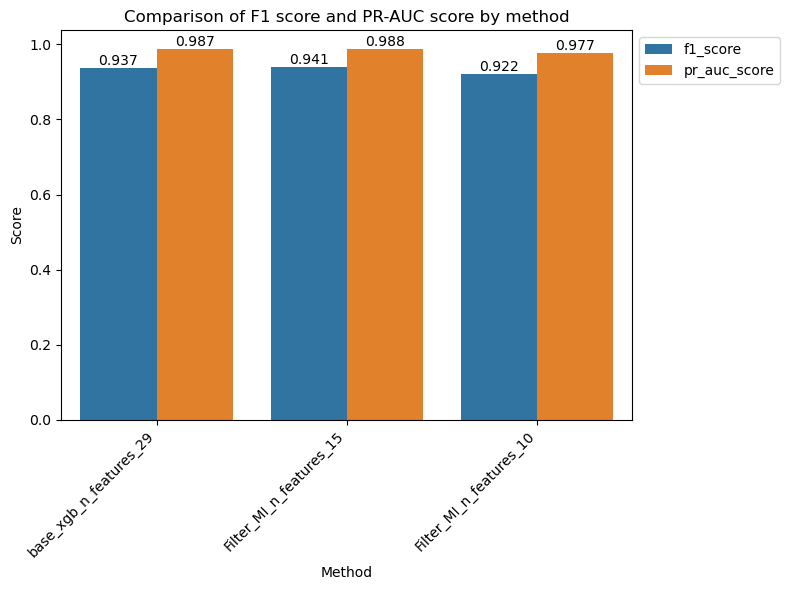

In [88]:
evaluator.calculate_update_score(base_model, method = 'Filter_MI', selected_features = mi_sel_features)
evaluator.plot_scores()

    Similarly, when the feature count drops below certain number, the PR-AUC score begins to decrease. Therefore, it’s preferable to keep around 15 features for optimal performance.

## 3-2. Wrapper Methods - Recursive feature Elimination (RFE)

In [90]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorers for weighted F1 and PR-AUC
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Use RFECV to perform RFE with cross-validation
# We specify 'f1' as the scoring to optimize F1-score during feature selection
selector = RFECV(estimator=base_model, step=1, cv=cv_strategy, scoring = weighted_f1_scorer, min_features_to_select=5)
selector.fit(X_train_scaled, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...),
      min_features_to_select=5,
      scoring=make_scorer(f1_score, average=weighted))

In [91]:
# Print selected feature names
selected_features = X_train.columns[selector.support_]
optimal_n_features = selector.n_features_
optimal_score = max(selector.cv_results_['mean_test_score'])
print("Optimal number of features : ", optimal_n_features)
print("Selected Features:", selected_features.to_list())
print("Cross-validated Weighted F1 Score at optimal features", round(optimal_score,2))

Optimal number of features :  29
Selected Features: ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin', 'ApplicationDayOfWeek_cos', 'EmploymentType_Employed - full time', 'EmploymentType_Employed - part time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_0', 'LoanPurpose_1', 'LoanPurpose_2', 'LoanPurpose_3']
Cross-validated Weighted F1 Score at optimal features 0.94


In [92]:
# Transform X to keep only the selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Re-fit the model on the training set with selected features
base_model.fit(X_train_selected, y_train)

# Predict probabilities on the test set to adjust the threshold
y_probs = base_model.predict_proba(X_test_selected)[:, 1]
y_pred = base_model.predict(X_test_selected)

# Try different thresholds to optimize F1 score
f1 = f1_score(y_test, y_pred, average= 'weighted')
pr_auc = average_precision_score(y_test, y_probs)
rfe_pr_auc = pr_auc

print("Weighted F1 score with selected features:", round(f1,3))
print("PR-AUC with selected features:", round(pr_auc,3))

Weighted F1 score with selected features: 0.937
PR-AUC with selected features: 0.987


In [93]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.937
base_xgb_n_features_29_pr_auc_score : 0.987


Wrapper_RFE_n_features_29_f1_score :, 0.937
Wrapper_RFE_n_features_29_pr_auc_score : 0.987


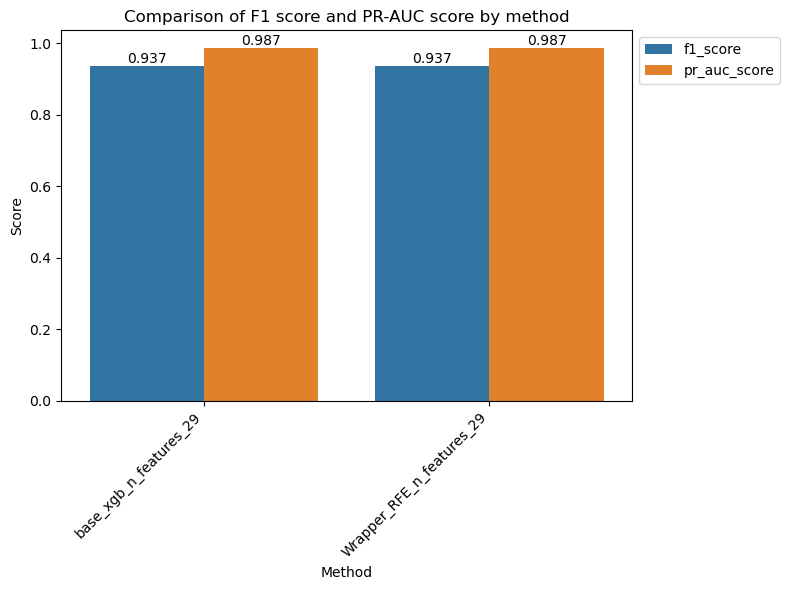

In [94]:
evaluator.calculate_update_score(base_model, method = 'Wrapper_RFE', selected_features = selected_features)
evaluator.plot_scores()

    This method yields 7 selected features and maintains decent scores

## 3-3. Embedded Methods

### Lasso

In [95]:
param_dist = {'C': loguniform(0.001, 1)}
feature_names = X.columns

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=weighted_f1_scorer, cv=cv, n_iter=10, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best C value and F1 score
best_C = random_search.best_params_['C']
best_score = random_search.best_score_
print(f"Best C from Random Search: {best_C}")
print(f"Best Weighted F1 Score from Random Search: {best_score:.3f}")

# Check the number of selected features
best_model = random_search.best_estimator_
num_selected_features = np.sum(best_model.coef_[0] != 0)
print(f"Number of selected features with best C: {num_selected_features}")
lasso_coefficients = best_model.coef_[0]
selected_features_lasso = [feature_names[i] for i, coef in enumerate(lasso_coefficients) if coef != 0]
print("Selected features by Lasso:", selected_features_lasso)

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best C from Random Search: 0.7114476009343418
Best Weighted F1 Score from Random Search: 0.888
Number of selected features with best C: 29
Selected features by Lasso: ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin', 'ApplicationDayOfWeek_cos', 'EmploymentType_Employed - full time', 'EmploymentType_Employed - part time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_0', 'LoanPurpose_1', 'LoanPurpose_2', 'LoanPurpose_3']


    This method resulted in 23 features, with an F1 score slightly lower than our previous model.

### Feature Importances

In [96]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.937
base_xgb_n_features_29_pr_auc_score : 0.987


In [138]:
# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = []

# For each fold, train the model and extract feature importance
for train_idx, val_idx in cv.split(X_train_scaled, y_train):

    # Split training and validation data
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    base_model.fit(X_fold_train, y_fold_train)

    # Store feature importances from this fold
    feature_importances.append(base_model.feature_importances_)

# Calculate the mean feature importance across all folds
mean_importances = np.mean(feature_importances, axis=0)

# Organize feature importances into a DataFrame for better readability
feature_names = X.columns.to_list()
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_importances})

# Custom scorer
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

In [139]:
#  Select the top N features
top_n = 30
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
top_n_features = selected_features_top_n['Feature'].values
print("Top N Features:\n", selected_features_top_n)

Top N Features:
                                  Feature  Importance
13  ALL_WorstPaymentStatusActiveAccounts    0.211526
0                                 Amount    0.059584
7               ALL_CountDefaultAccounts    0.055947
12    ALL_SumCurrentOutstandingBalExcMtg    0.039215
10                    ALL_MeanAccountAge    0.038406
5                        ALL_CountActive    0.037308
22   EmploymentType_Employed - part time    0.037167
8            ALL_CountOpenedLast12Months    0.034625
11          ALL_SumCurrentOutstandingBal    0.033140
28                         LoanPurpose_3    0.031592
21   EmploymentType_Employed - full time    0.027520
1                                   Term    0.026141
4                              ALL_Count    0.026057
14                  DaysSinceApplication    0.025666
6            ALL_CountClosedLast12Months    0.024855
3               ALL_AgeOfYoungestAccount    0.023823
27                         LoanPurpose_2    0.023467
2                 ALL_AgeOfOl

In [146]:
def number_of_top_features_fi(n):
    selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(n)
    evaluator.calculate_update_score(base_model, method = 'FeatureImportance', selected_features = selected_features_top_n['Feature'].values)
    # evaluator.plot_scores()

base_xgb_n_features_29_f1_score :, 0.886
base_xgb_n_features_29_pr_auc_score : 0.433
FeatureImportance_n_features_3_f1_score :, 0.845
FeatureImportance_n_features_3_pr_auc_score : 0.279
FeatureImportance_n_features_4_f1_score :, 0.855
FeatureImportance_n_features_4_pr_auc_score : 0.268
FeatureImportance_n_features_5_f1_score :, 0.877
FeatureImportance_n_features_5_pr_auc_score : 0.371
FeatureImportance_n_features_6_f1_score :, 0.88
FeatureImportance_n_features_6_pr_auc_score : 0.404
FeatureImportance_n_features_7_f1_score :, 0.877
FeatureImportance_n_features_7_pr_auc_score : 0.428
FeatureImportance_n_features_8_f1_score :, 0.877
FeatureImportance_n_features_8_pr_auc_score : 0.419
FeatureImportance_n_features_9_f1_score :, 0.885
FeatureImportance_n_features_9_pr_auc_score : 0.423


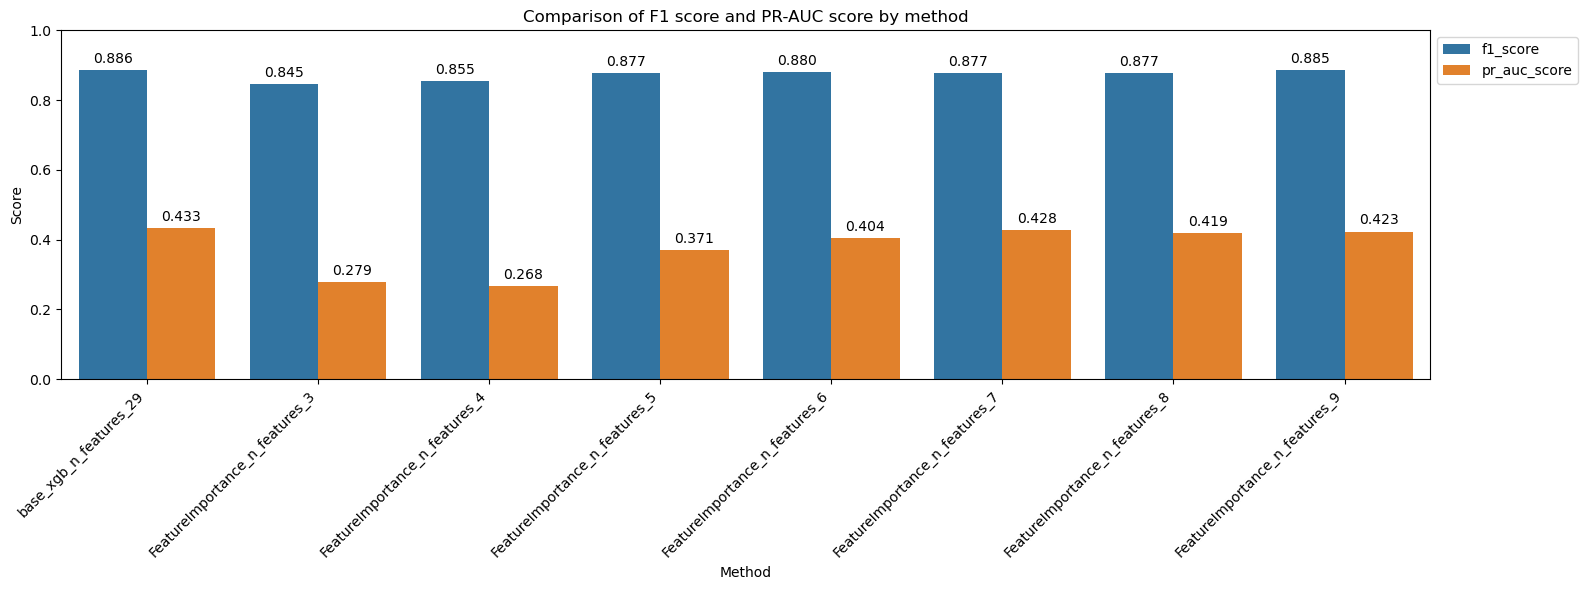

In [147]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

for i in range(3,10):
    number_of_top_features_fi(i)

evaluator.plot_scores()

base_xgb_n_features_29_f1_score :, 0.886
base_xgb_n_features_29_pr_auc_score : 0.433
FeatureImportance_n_features_10_f1_score :, 0.881
FeatureImportance_n_features_10_pr_auc_score : 0.421
FeatureImportance_n_features_11_f1_score :, 0.889
FeatureImportance_n_features_11_pr_auc_score : 0.436
FeatureImportance_n_features_12_f1_score :, 0.885
FeatureImportance_n_features_12_pr_auc_score : 0.431
FeatureImportance_n_features_13_f1_score :, 0.884
FeatureImportance_n_features_13_pr_auc_score : 0.425
FeatureImportance_n_features_14_f1_score :, 0.889
FeatureImportance_n_features_14_pr_auc_score : 0.443
FeatureImportance_n_features_15_f1_score :, 0.883
FeatureImportance_n_features_15_pr_auc_score : 0.434
FeatureImportance_n_features_16_f1_score :, 0.884
FeatureImportance_n_features_16_pr_auc_score : 0.44
FeatureImportance_n_features_17_f1_score :, 0.88
FeatureImportance_n_features_17_pr_auc_score : 0.416
FeatureImportance_n_features_18_f1_score :, 0.88
FeatureImportance_n_features_18_pr_auc_score

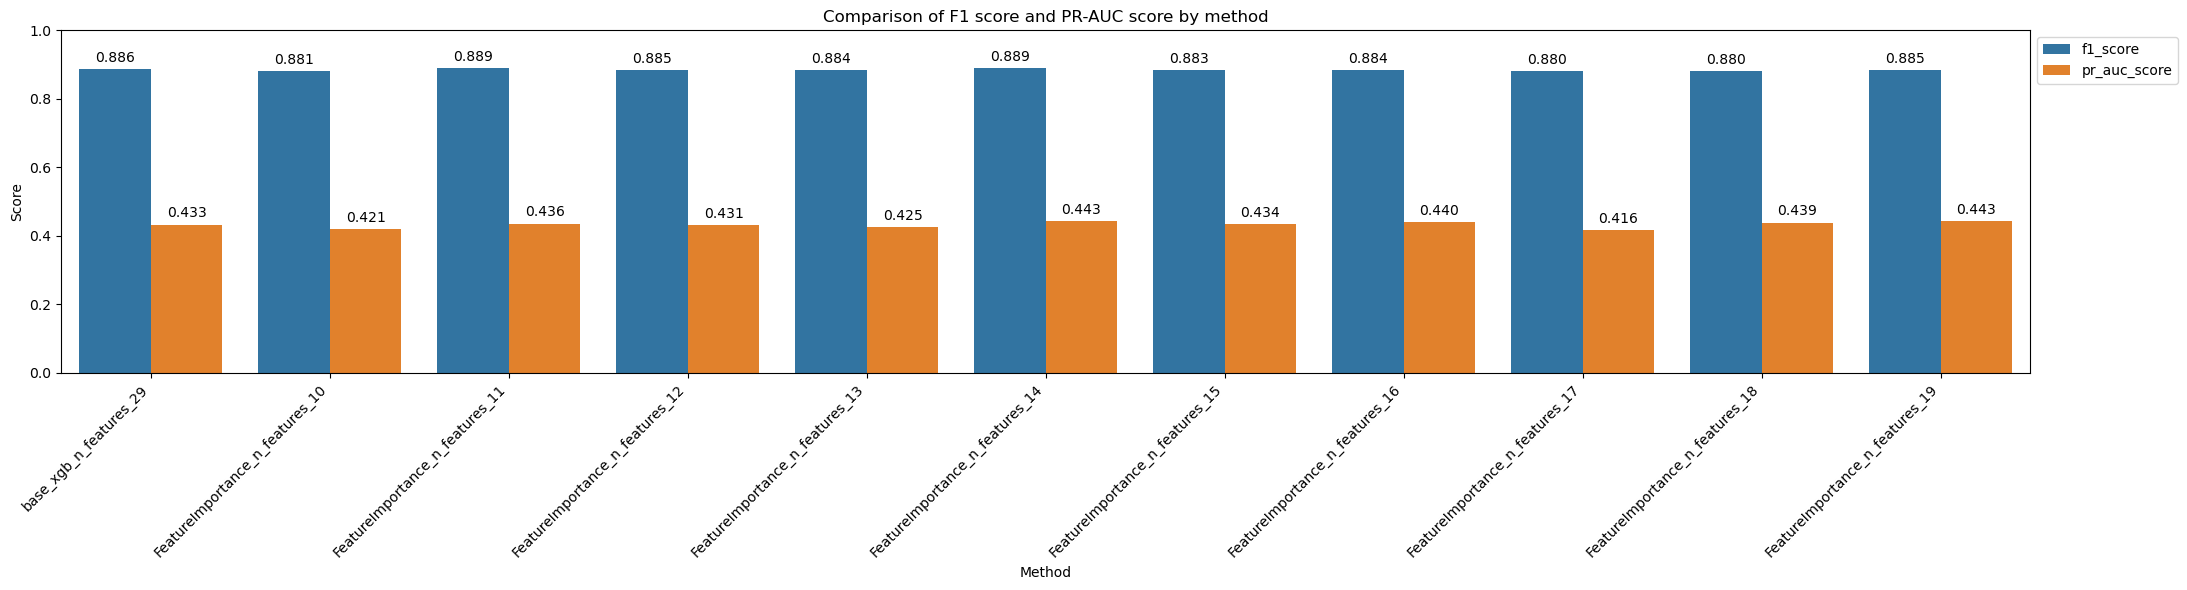

In [145]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

for i in range(10,20):
    number_of_top_features_fi(i)

evaluator.plot_scores()

In [141]:
top_n = 10
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)
# It means those features are really important

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time' 'ALL_CountOpenedLast12Months'
 'ALL_SumCurrentOutstandingBal' 'LoanPurpose_3']


In [168]:
top_n = 15
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(list(fi_top_n_features))

['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_CountDefaultAccounts', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_MeanAccountAge', 'ALL_CountActive', 'EmploymentType_Employed - part time', 'ALL_CountOpenedLast12Months', 'ALL_SumCurrentOutstandingBal', 'LoanPurpose_3', 'EmploymentType_Employed - full time', 'Term', 'ALL_Count', 'DaysSinceApplication', 'ALL_CountClosedLast12Months']


In [143]:
top_n = 20
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time' 'ALL_CountOpenedLast12Months'
 'ALL_SumCurrentOutstandingBal' 'LoanPurpose_3'
 'EmploymentType_Employed - full time' 'Term' 'ALL_Count'
 'DaysSinceApplication' 'ALL_CountClosedLast12Months'
 'ALL_AgeOfYoungestAccount' 'LoanPurpose_2' 'ALL_AgeOfOldestAccount'
 'ApplicationDay_sin' 'ApplicationDay_cos']


    Selecting the top 15–20 features seems like the most efficient and effective approach, ensuring strong performance while maintaining interpretability and reducing unnecessary complexity.

## 3-4. PCA (Dimentionality Reduction)

In [158]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.886
base_xgb_n_features_29_pr_auc_score : 0.433


In [165]:
pca = PCA(n_components=10)
pca_X_train = pca.fit_transform(X_train_scaled)
pca_X_test = pca.transform(X_test_scaled)

PCA_n_features_10_f1_score :, 0.848
PCA_n_features_10_pr_auc_score : 0.25


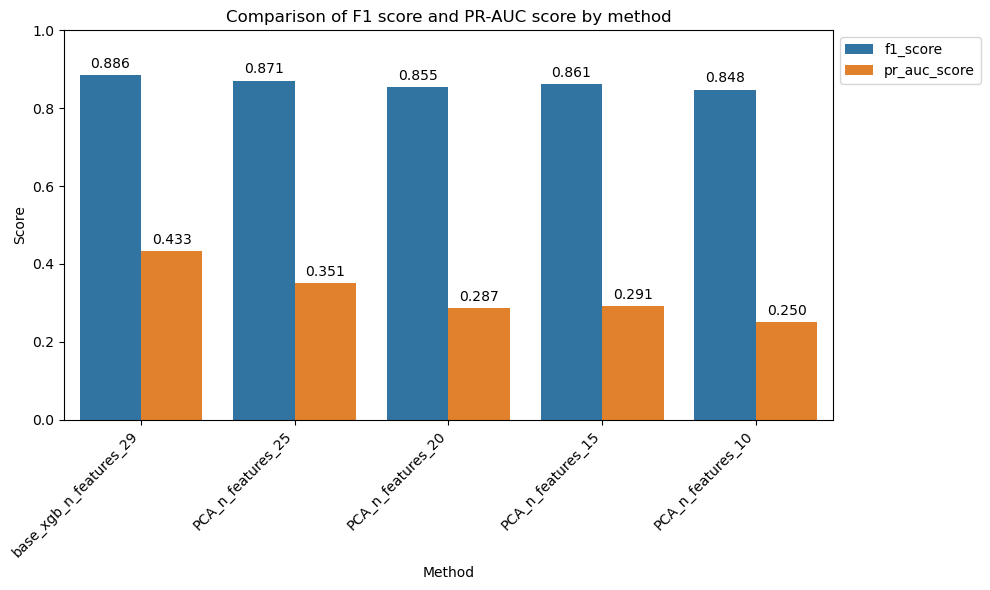

In [166]:
evaluator.calculate_update_score(base_model, method = 'PCA', selected_features = 'manual', manual_X_train= pca_X_train, manual_X_test=pca_X_test)
evaluator.plot_scores()

    For PCA, as we reduced the dimensionality, both the F1 and PR-AUC scores progressively decreased. Therefore, we decided not to consider this approach for this time.

# 4. Modeling & Evaluation

We have three main objectives:

	1.	Improve performance by tuning hyperparameters while keeping all features intact.
	2.	Reduce the number of features to lower model complexity, aiming to achieve similar or better performance.
	3.	Reduce the number of features and tune hyperparameters to achieve similar or better performance.

And we will check them step by step  

	1.	base model itself.  
	2.	base model + selected features.  
	3.	hyper param tuned model + selected features.  


In [268]:
def evaluate_model(model, x_test, y_test, desired_precision):
    # Predict test data
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
    pr_auc = round(average_precision_score(y_test, y_probs), 3)

    # Display Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    clf_report = clf_report.round(3)

    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # Plot the Precision-Recall curve
    plt.figure(figsize=(5, 3))
    plt.plot(recall, precision, marker='.', label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{type(model).__name__}_feature_{x_test.shape[1]}_Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final metrics
    print('F1 Score:', f1)
    print('PR-AUC Score:', pr_auc)
    # print('Accuracy:', acc)
    # print('Precision:', prec)
    # print('Recall:', rec)
    print('-------------------------------------------------------')
    # print('Confusion Matrix:\n', cm)
    # print('--------------------------------')
    print('Classification Report:\n', clf_report)

    # Precision-Recall curve and threshold adjustment
    
    # best_f1 = 0
    # best_threshold = 0
    # for threshold in thresholds:
    #     y_pred_adjusted = (y_probs >= threshold).astype(int)
    #     precision = precision_score(y_test, y_pred_adjusted)
    #     recall = recall_score(y_test, y_pred_adjusted)
    #     f1 = 2 * (precision * recall) / (precision + recall)
    #     if f1 > best_f1:
    #         best_f1 = f1
    #         best_threshold = threshold
    # print('******************************************************')
    # print(f"Optimal Threshold: {best_threshold:.3f}, Best F1 Score: {best_f1:.3f}, Precision : {precision:.3f}, Recall : {recall:.3f}")
    # print('-------------------------------------------------------')

    selected_threshold = None
    for p, r, t in zip(precision, recall, thresholds):
        if p >= desired_precision:
            selected_threshold = t
            y_pred_adjusted = (y_probs >= selected_threshold).astype(int)

            # Calculate precision and recall at the adjusted threshold
            precision_adj = precision_score(y_test, y_pred_adjusted)
            recall_adj = recall_score(y_test, y_pred_adjusted)

            print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
            print('-------------------------------------------------------')
            break

In [270]:
def evaluate_iter(model):
    plot_machine = ModelEvaluator()
    model.fit(X_train_scaled, y_train)
    evaluate_model(model, X_test_scaled, y_test, 0.7)
    plot_machine.calculate_update_score(model, method = type(model).__name__, selected_features = X.columns)
    for feature_list in [all_common, common_in_four, common_in_three]:
        model.fit(X_train_scaled[feature_list], y_train)
        evaluate_model(model, X_test_scaled[feature_list], y_test, 0.7)
        plot_machine.calculate_update_score(lgbm_clf, method = type(model).__name__, selected_features = feature_list)

    
    plot_machine.plot_scores()

These are the lists of top-n features selected by each method

In [170]:
corr_list = ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_MeanAccountAge','ALL_CountOpenedLast12Months',
 'ALL_CountActive','ALL_AgeOfOldestAccount','ALL_SumCurrentOutstandingBalExcMtg','DaysSinceApplication',
 'ALL_CountClosedLast12Months','ALL_SumCurrentOutstandingBal','ApplicationMonth_sin',
 'EmploymentType_Employed - part time','ApplicationDay_sin','EmploymentType_Self employed','LoanPurpose_2']

mi_list = ['Amount', 'ALL_AgeOfOldestAccount', 'ALL_Count', 'ALL_CountActive',
       'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months',
       'ALL_CountSettled', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_WorstPaymentStatusActiveAccounts', 'ApplicationDay_sin',
       'ApplicationDayOfWeek_sin', 'LoanPurpose_0', 'LoanPurpose_1']

rfe_list = ['Amount', 'ALL_CountActive', 'ALL_CountDefaultAccounts', 'ALL_MeanAccountAge',
   'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'EmploymentType_Employed - part time']

lasso_list = ['Amount', 'Term', 'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountClosedLast12Months',
   'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal',
   'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication',
   'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_cos'
   'EmploymentType_Employed - part time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_2', 'LoanPurpose_3']

fi_list = ['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_CountDefaultAccounts', 'ALL_SumCurrentOutstandingBalExcMtg',
  'ALL_MeanAccountAge', 'ALL_CountActive', 'EmploymentType_Employed - part time', 'ALL_CountOpenedLast12Months',
  'ALL_SumCurrentOutstandingBal', 'LoanPurpose_3', 'EmploymentType_Employed - full time', 'Term',
  'ALL_Count', 'DaysSinceApplication', 'ALL_CountClosedLast12Months']

In [ ]:
from collections import Counter
all_lists = [corr_list, mi_list, rfe_list, lasso_list, fi_list]
element_counts = Counter(item for sublist in all_lists for item in sublist)
all_common = [item for item, count in element_counts.items() if count == 5]
common_in_four = [item for item, count in element_counts.items() if count >= 4]
common_in_three = [item for item, count in element_counts.items() if count >= 3]

In [178]:
print("All common (in all 5 lists):", len(all_common))
print("Common in more than 4 lists:", len(common_in_four))
print("Common in more than 3 lists:", len(common_in_three))

All common (in all 5 lists): 5
Common in more than 4 lists: 8
Common in more than 3 lists: 13


In [179]:
all_common

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg']

In [180]:
common_in_four

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'ALL_SumCurrentOutstandingBal',
 'ALL_CountDefaultAccounts']

In [181]:
common_in_three

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'DaysSinceApplication',
 'ALL_CountClosedLast12Months',
 'ALL_SumCurrentOutstandingBal',
 'EmploymentType_Employed - part time',
 'ApplicationDay_sin',
 'ALL_Count',
 'ALL_CountDefaultAccounts']

### Random Forest

basic model with all features

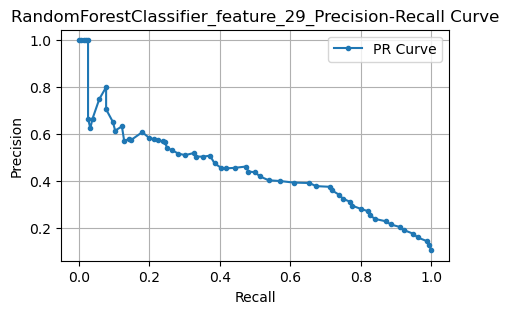

F1 Score: 0.864
PR-AUC Score: 0.439
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.903   0.992     0.945  1311.000
1                 0.615   0.103     0.176   156.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.759   0.547     0.561  1467.000
weighted avg      0.872   0.898     0.864  1467.000
Threshold: 0.53, Precision: 0.71, Recall: 0.08
-------------------------------------------------------
RandomForestClassifier_n_features_29_f1_score :, 0.864
RandomForestClassifier_n_features_29_pr_auc_score : 0.439


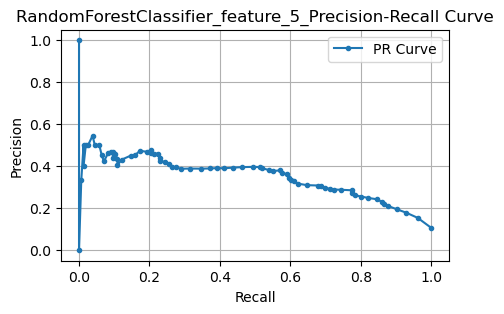

F1 Score: 0.868
PR-AUC Score: 0.347
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.909   0.977     0.942  1311.000
1                 0.474   0.173     0.254   156.000
accuracy          0.892   0.892     0.892     0.892
macro avg         0.691   0.575     0.598  1467.000
weighted avg      0.862   0.892     0.868  1467.000
RandomForestClassifier_n_features_5_f1_score :, 0.875
RandomForestClassifier_n_features_5_pr_auc_score : 0.414


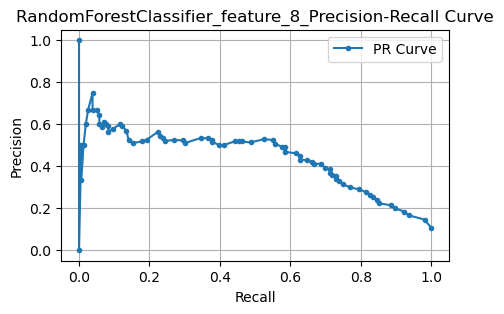

F1 Score: 0.873
PR-AUC Score: 0.438
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.911   0.979     0.944  1311.000
1                 0.526   0.192     0.282   156.000
accuracy          0.896   0.896     0.896     0.896
macro avg         0.718   0.586     0.613  1467.000
weighted avg      0.870   0.896     0.873  1467.000
Threshold: 0.71, Precision: 0.75, Recall: 0.04
-------------------------------------------------------
RandomForestClassifier_n_features_8_f1_score :, 0.882
RandomForestClassifier_n_features_8_pr_auc_score : 0.444


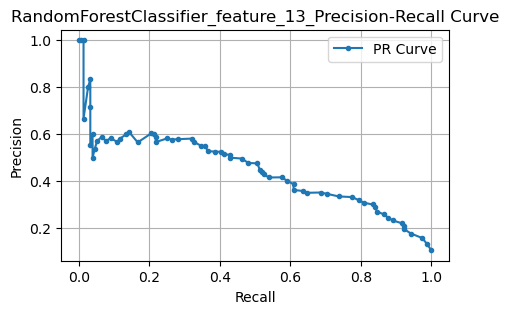

F1 Score: 0.872
PR-AUC Score: 0.443
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.909   0.985     0.945  1311.000
1                 0.565   0.167     0.257   156.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.737   0.576     0.601  1467.000
weighted avg      0.872   0.898     0.872  1467.000
Threshold: 0.65, Precision: 0.71, Recall: 0.03
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
RandomForestClassifier_n_features_13_f1_score :, 0.878
RandomForestClassifier_n_features_13_pr_auc_score : 0.474


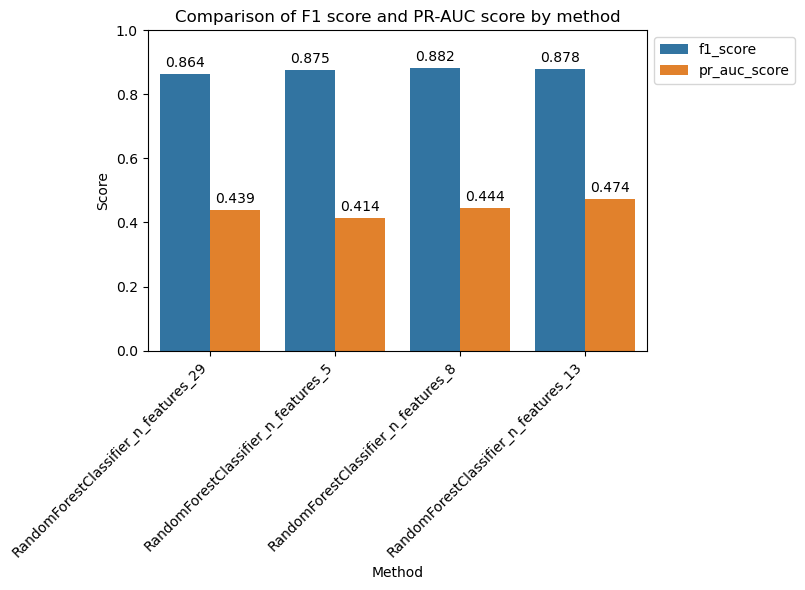

In [271]:
rf_clf = RandomForestClassifier(random_state=0, class_weight = 'balanced')
evaluate_iter(rf_clf)

hyperparam tuned model with 8 features selected

In [266]:
rf_clf = RandomForestClassifier(random_state=0)
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf_clf_cv = RandomizedSearchCV(rf_clf, param_distributions, n_iter=100, scoring='average_precision', cv=5, random_state=42, n_jobs=-1)
rf_clf_cv.fit(X_train[common_in_three], y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x185a6a1f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x185955190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18572fc10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1857cc310>},
                   random_state=42, scoring='average_precision')

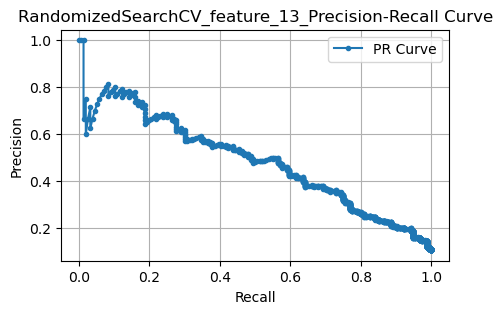

F1 Score: 0.851
PR-AUC Score: 0.49
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.897   0.998     0.945  1311.000
1                 0.714   0.032     0.061   156.000
accuracy          0.896   0.896     0.896     0.896
macro avg         0.805   0.515     0.503  1467.000
weighted avg      0.877   0.896     0.851  1467.000
Threshold: 0.43, Precision: 0.71, Recall: 0.19
-------------------------------------------------------


In [272]:
# Evaluate Model
evaluate_model(rf_clf_cv, X_test[common_in_three], y_test, 0.7)

### GBM

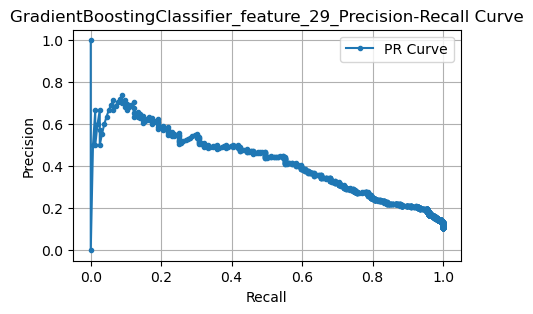

F1 Score: 0.875
PR-AUC Score: 0.43
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.910   0.986     0.947   1311.0
1                 0.609   0.179     0.277    156.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.759   0.583     0.612   1467.0
weighted avg      0.878   0.900     0.875   1467.0
Threshold: 0.55, Precision: 0.70, Recall: 0.12
-------------------------------------------------------
GradientBoostingClassifier_n_features_29_f1_score :, 0.875
GradientBoostingClassifier_n_features_29_pr_auc_score : 0.43


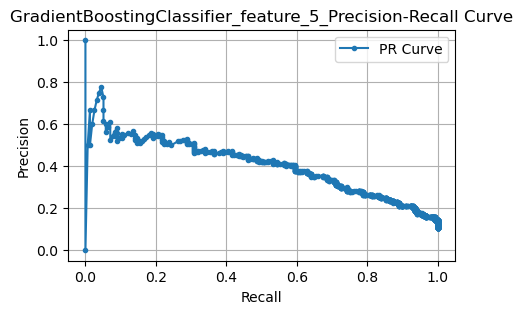

F1 Score: 0.86
PR-AUC Score: 0.411
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.901   0.990     0.944  1311.000
1                 0.519   0.090     0.153   156.000
accuracy          0.894   0.894     0.894     0.894
macro avg         0.710   0.540     0.548  1467.000
weighted avg      0.861   0.894     0.860  1467.000
Threshold: 0.58, Precision: 0.73, Recall: 0.05
-------------------------------------------------------
GradientBoostingClassifier_n_features_5_f1_score :, 0.875
GradientBoostingClassifier_n_features_5_pr_auc_score : 0.414


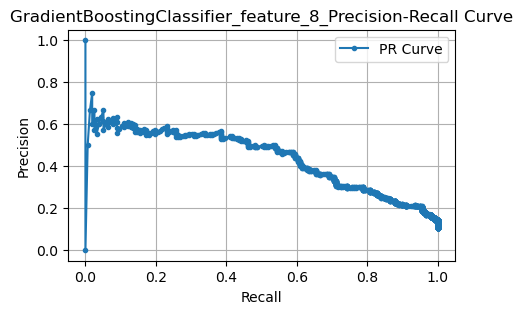

F1 Score: 0.878
PR-AUC Score: 0.445
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.913   0.981     0.946  1311.000
1                 0.569   0.212     0.308   156.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.741   0.596     0.627  1467.000
weighted avg      0.876   0.899     0.878  1467.000
Threshold: 0.71, Precision: 0.75, Recall: 0.02
-------------------------------------------------------
GradientBoostingClassifier_n_features_8_f1_score :, 0.882
GradientBoostingClassifier_n_features_8_pr_auc_score : 0.444


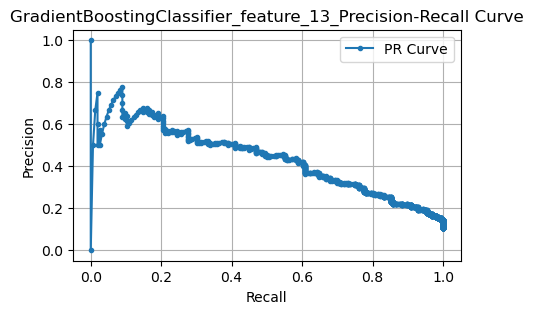

F1 Score: 0.88
PR-AUC Score: 0.44
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.912   0.986     0.948  1311.000
1                 0.627   0.205     0.309   156.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.770   0.595     0.628  1467.000
weighted avg      0.882   0.903     0.880  1467.000
Threshold: 0.59, Precision: 0.70, Recall: 0.09
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
GradientBoostingClassifier_n_features_13_f1_score :, 0.878
GradientBoostingClassifier_n_features_13_pr_auc_score : 0.474


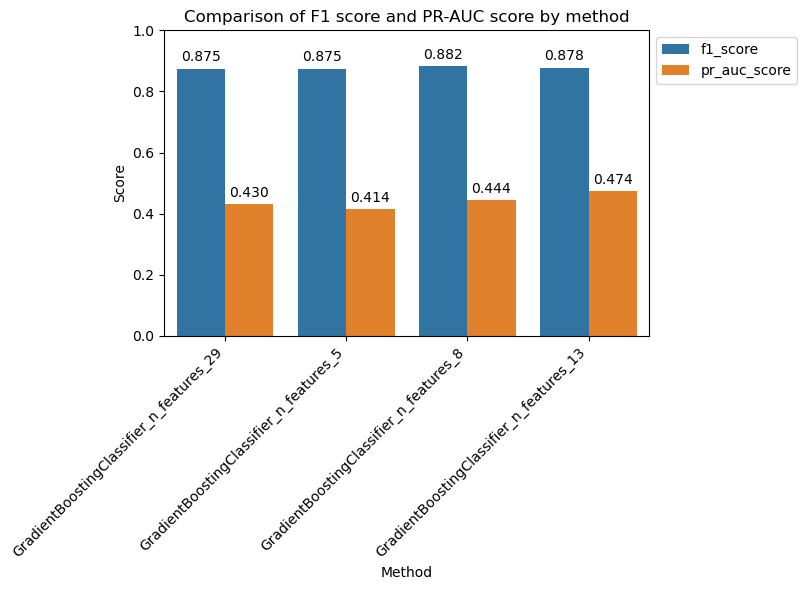

In [273]:
gbm_clf = GradientBoostingClassifier(random_state=0)
evaluate_iter(gbm_clf)

In [228]:
gbm_clf = GradientBoostingClassifier()
param_distributions = {
    'learning_rate': uniform(0.01, 0.29),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10)
}

gbm_clf_cv = RandomizedSearchCV(gbm_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs = -1)
gbm_clf_cv.fit(X_train_scaled[common_in_four], y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1843851c0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1831ab280>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x182f5ca60>},
                   random_state=42, scoring='average_precision')

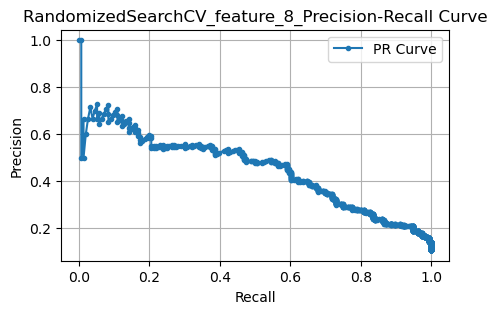

F1 Score: 0.873
PR-AUC Score: 0.455
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.909   0.986     0.946  1311.000
1                 0.591   0.167     0.260   156.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.750   0.576     0.603  1467.000
weighted avg      0.875   0.899     0.873  1467.000
Threshold: 0.57, Precision: 0.71, Recall: 0.11
-------------------------------------------------------


In [229]:
# Evaluate Model
evaluate_model(gbm_clf_cv, X_test_scaled[common_in_four], y_test, 0.7)

### XGBoost

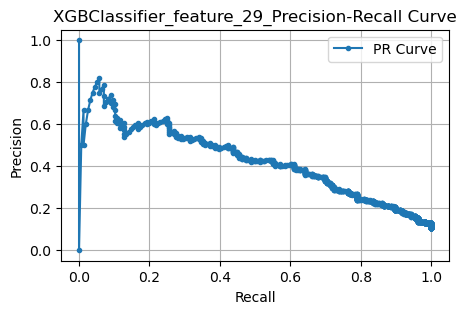

F1 Score: 0.886
PR-AUC Score: 0.433
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.922   0.967     0.944  1311.000
1                 0.533   0.314     0.395   156.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.727   0.641     0.670  1467.000
weighted avg      0.881   0.898     0.886  1467.000
Threshold: 0.81, Precision: 0.71, Recall: 0.10
-------------------------------------------------------
XGBClassifier_n_features_29_f1_score :, 0.886
XGBClassifier_n_features_29_pr_auc_score : 0.433


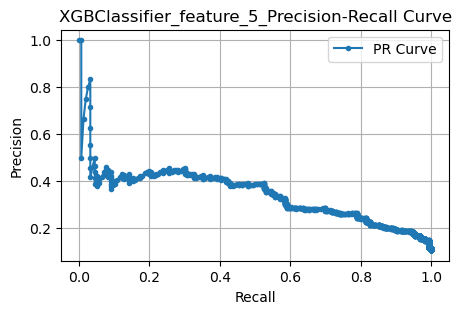

F1 Score: 0.872
PR-AUC Score: 0.352
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.916   0.960     0.937  1311.000
1                 0.435   0.256     0.323   156.000
accuracy          0.885   0.885     0.885     0.885
macro avg         0.675   0.608     0.630  1467.000
weighted avg      0.865   0.885     0.872  1467.000
Threshold: 0.84, Precision: 0.71, Recall: 0.03
-------------------------------------------------------
XGBClassifier_n_features_5_f1_score :, 0.875
XGBClassifier_n_features_5_pr_auc_score : 0.414


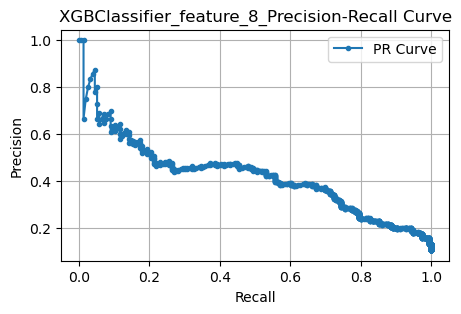

F1 Score: 0.874
PR-AUC Score: 0.427
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.918   0.959     0.938  1311.000
1                 0.443   0.276     0.340   156.000
accuracy          0.886   0.886     0.886     0.886
macro avg         0.680   0.617     0.639  1467.000
weighted avg      0.867   0.886     0.874  1467.000
Threshold: 0.84, Precision: 0.70, Recall: 0.09
-------------------------------------------------------
XGBClassifier_n_features_8_f1_score :, 0.882
XGBClassifier_n_features_8_pr_auc_score : 0.444


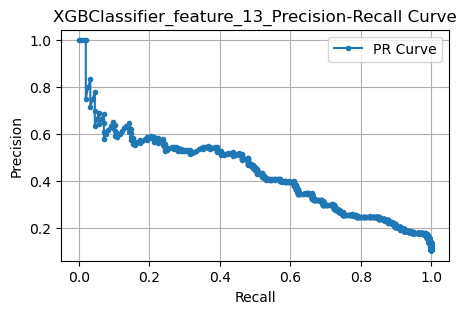

F1 Score: 0.884
PR-AUC Score: 0.44
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.920   0.969     0.944  1311.000
1                 0.529   0.295     0.379   156.000
accuracy          0.897   0.897     0.897     0.897
macro avg         0.725   0.632     0.661  1467.000
weighted avg      0.879   0.897     0.884  1467.000
Threshold: 0.90, Precision: 0.70, Recall: 0.04
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
XGBClassifier_n_features_13_f1_score :, 0.878
XGBClassifier_n_features_13_pr_auc_score : 0.474


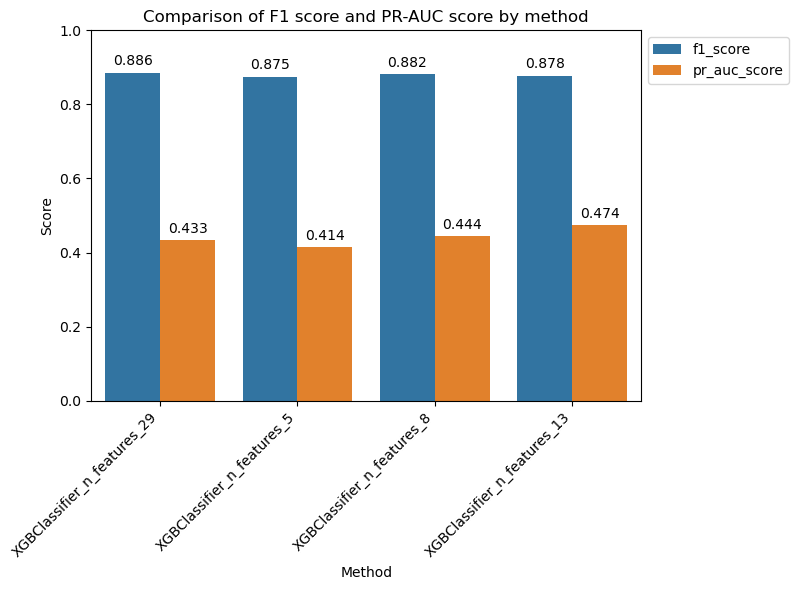

In [274]:
xgb_clf = XGBClassifier(random_state = 42)
evaluate_iter(xgb_clf)

In [231]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'scale_pos_weight': [scale_pos_weight]
}

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
xgb_clf_cv = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='average_precision',  # Use PR-AUC (average precision) as the scoring metric
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_clf_cv.fit(X_train_scaled[common_in_four], y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18478d0a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17bc9ec40>,
                                        'scale_pos_weight': [8.403846153846153],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x184a27610>},
                   random_state=42, scoring='average_precision')

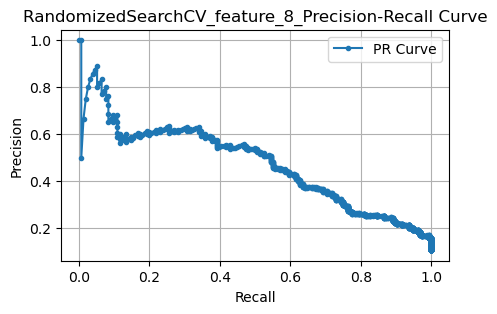

F1 Score: 0.805
PR-AUC Score: 0.478
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.964   0.764     0.853  1311.000
1                 0.278   0.763     0.408   156.000
accuracy          0.764   0.764     0.764     0.764
macro avg         0.621   0.764     0.630  1467.000
weighted avg      0.891   0.764     0.805  1467.000
Threshold: 0.90, Precision: 0.72, Recall: 0.08
-------------------------------------------------------


In [275]:
# Evaluate Model
evaluate_model(xgb_clf_cv, X_test_scaled[common_in_four], y_test, desired_precision= 0.7)

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


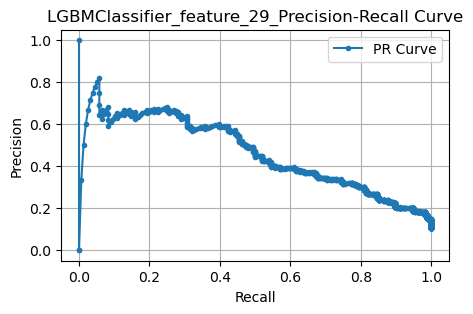

F1 Score: 0.89
PR-AUC Score: 0.465
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.920   0.981     0.949  1311.000
1                 0.638   0.282     0.391   156.000
accuracy          0.907   0.907     0.907     0.907
macro avg         0.779   0.631     0.670  1467.000
weighted avg      0.890   0.907     0.890  1467.000
Threshold: 0.71, Precision: 0.75, Recall: 0.06
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBMClassifier_n_features_29_f1_score :, 0.89
LGBMClassifier_n_features_29_pr_auc_score : 0.465


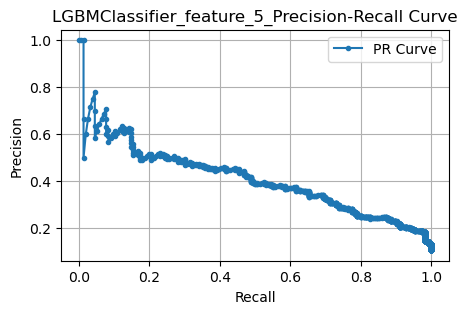

F1 Score: 0.875
PR-AUC Score: 0.414
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.913   0.975     0.943  1311.000
1                 0.507   0.218     0.305   156.000
accuracy          0.894   0.894     0.894     0.894
macro avg         0.710   0.596     0.624  1467.000
weighted avg      0.870   0.894     0.875  1467.000
Threshold: 0.67, Precision: 0.71, Recall: 0.08
-------------------------------------------------------
LGBMClassifier_n_features_5_f1_score :, 0.875
LGBMClassifier_n_features_5_pr_auc_score : 0.414


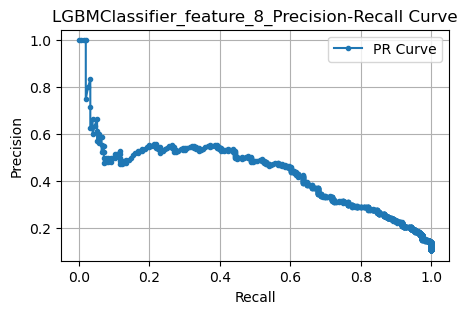

F1 Score: 0.882
PR-AUC Score: 0.444
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.918   0.972     0.944  1311.000
1                 0.532   0.269     0.357   156.000
accuracy          0.897   0.897     0.897     0.897
macro avg         0.725   0.621     0.651  1467.000
weighted avg      0.877   0.897     0.882  1467.000
Threshold: 0.83, Precision: 0.71, Recall: 0.03
-------------------------------------------------------
LGBMClassifier_n_features_8_f1_score :, 0.882
LGBMClassifier_n_features_8_pr_auc_score : 0.444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


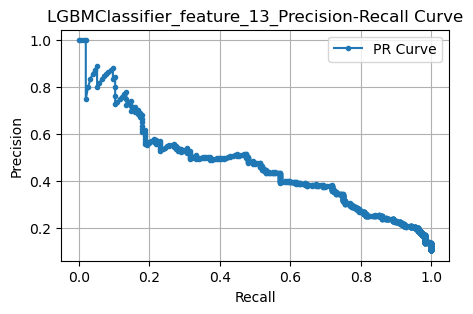

F1 Score: 0.878
PR-AUC Score: 0.474
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.914   0.976     0.944  1311.000
1                 0.537   0.231     0.323   156.000
accuracy          0.897   0.897     0.897     0.897
macro avg         0.726   0.604     0.634  1467.000
weighted avg      0.874   0.897     0.878  1467.000
Threshold: 0.59, Precision: 0.70, Recall: 0.17
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBMClassifier_n_features_13_f1_score :, 0.878
LGBMClassifier_n_features_13_pr_auc_score : 0.474


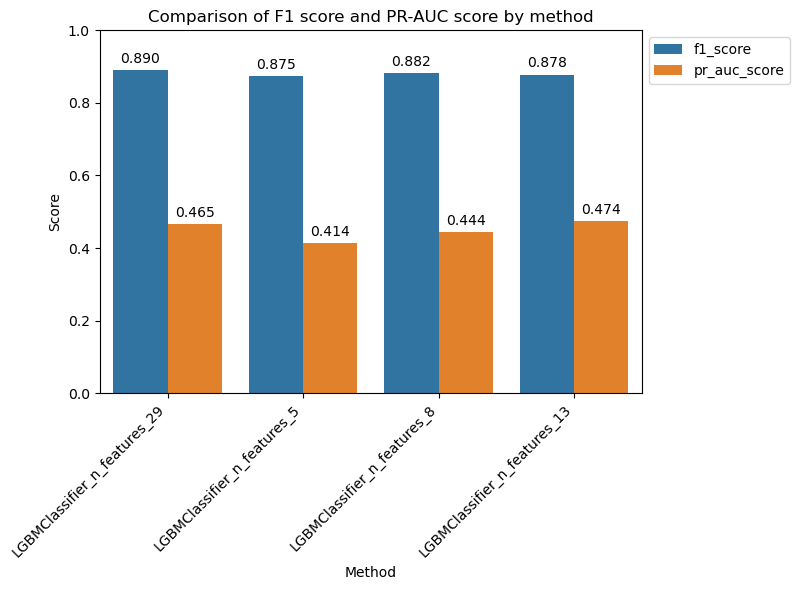

In [276]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0, force_row_wise='true')
evaluate_iter(lgbm_clf)

In [236]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_split_gain': [0.0, 0.1, 0.2],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

lgbm_clf_cv = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring= 'average_precision',
    cv=5,
    random_state=42,
    n_jobs=-1
)

lgbm_clf_cv.fit(X_train_scaled[common_in_three], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise='true',
                                            random_state=42, verbose=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 10, -1],
                                        'min_child_samples': [10, 20, 30],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [20, 31, 40, 50],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='average_precision')

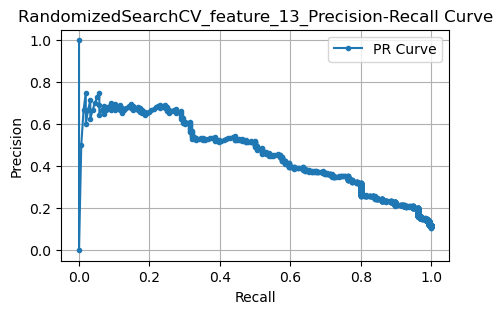

F1 Score: 0.875
PR-AUC Score: 0.471
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.908   0.991     0.948  1311.000
1                 0.676   0.160     0.259   156.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.792   0.576     0.603  1467.000
weighted avg      0.884   0.903     0.875  1467.000
Threshold: 0.55, Precision: 0.70, Recall: 0.09
-------------------------------------------------------


In [ ]:
# Evaluate Model
evaluate_model(lgbm_clf_cv, X_test_scaled[common_in_three], y_test, desired_precision= 0.7)

### CatBoost

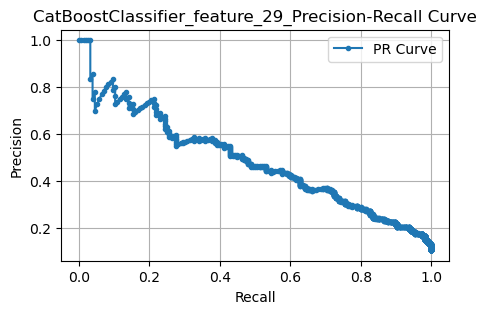

F1 Score: 0.886
PR-AUC Score: 0.49
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.917   0.981     0.948  1311.000
1                 0.615   0.256     0.362   156.000
accuracy          0.904   0.904     0.904     0.904
macro avg         0.766   0.619     0.655  1467.000
weighted avg      0.885   0.904     0.886  1467.000
Threshold: 0.55, Precision: 0.71, Recall: 0.22
-------------------------------------------------------
CatBoostClassifier_n_features_29_f1_score :, 0.886
CatBoostClassifier_n_features_29_pr_auc_score : 0.49


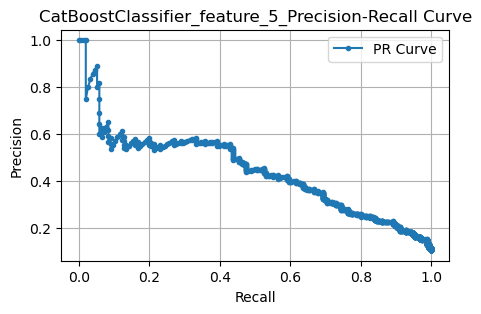

F1 Score: 0.877
PR-AUC Score: 0.447
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.913   0.980     0.945  1311.000
1                 0.559   0.212     0.307   156.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.736   0.596     0.626  1467.000
weighted avg      0.875   0.898     0.877  1467.000
Threshold: 0.68, Precision: 0.75, Recall: 0.06
-------------------------------------------------------
CatBoostClassifier_n_features_5_f1_score :, 0.875
CatBoostClassifier_n_features_5_pr_auc_score : 0.414


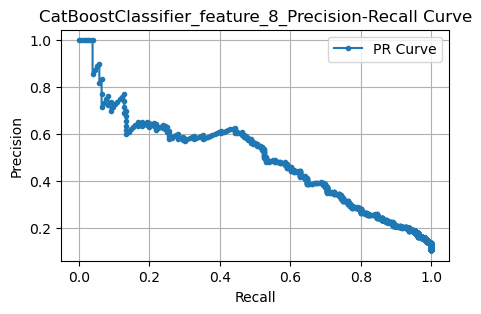

F1 Score: 0.887
PR-AUC Score: 0.502
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.920   0.976     0.947  1311.000
1                 0.584   0.288     0.386   156.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.752   0.632     0.667  1467.000
weighted avg      0.884   0.903     0.887  1467.000
Threshold: 0.70, Precision: 0.70, Recall: 0.13
-------------------------------------------------------
CatBoostClassifier_n_features_8_f1_score :, 0.882
CatBoostClassifier_n_features_8_pr_auc_score : 0.444


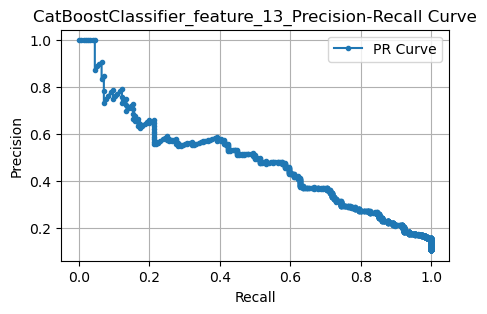

F1 Score: 0.884
PR-AUC Score: 0.49
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.919   0.973     0.945  1311.000
1                 0.550   0.282     0.373   156.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.735   0.627     0.659  1467.000
weighted avg      0.880   0.899     0.884  1467.000
Threshold: 0.61, Precision: 0.71, Recall: 0.15
-------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
CatBoostClassifier_n_features_13_f1_score :, 0.878
CatBoostClassifier_n_features_13_pr_auc_score : 0.474


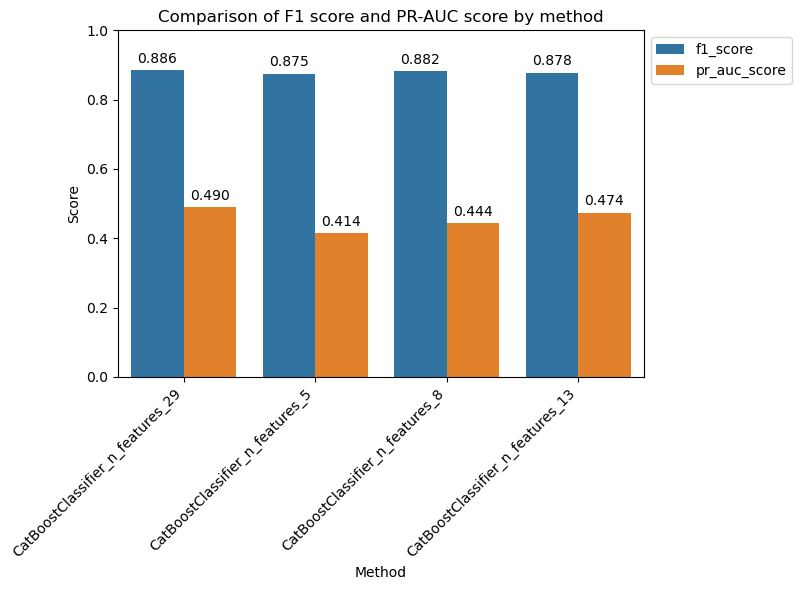

In [278]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
evaluate_iter(cb_clf)

In [244]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV for CatBoost
param_distributions = {
    'iterations': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(3, 10),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(0, 1),
    'border_count': randint(32, 255),
    'scale_pos_weight': [scale_pos_weight]
}

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
cb_clf_cv = RandomizedSearchCV(
    estimator=cb_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='average_precision',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
cb_clf_cv.fit(X_train_scaled[common_in_three], y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x184e33700>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x184f3a220>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x184feb3d0>,
                                        'depth': <scipy.stats._distn_infras...
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x184d89430>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x183be1400>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1850a6be0>,
                                        'scale_pos_weight': [8.403846153846153]},
                   random_state=42, scoring='average_precision')

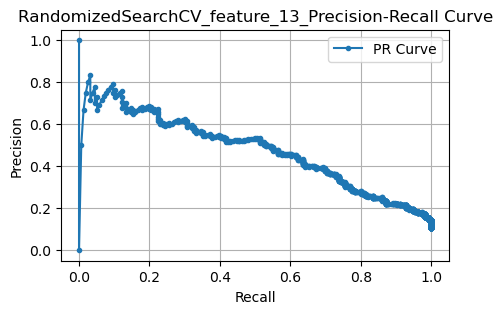

F1 Score: 0.815
PR-AUC Score: 0.481
-------------------------------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.967   0.777     0.861  1311.000
1                 0.292   0.776     0.425   156.000
accuracy          0.776   0.776     0.776     0.776
macro avg         0.630   0.776     0.643  1467.000
weighted avg      0.895   0.776     0.815  1467.000
Threshold: 0.88, Precision: 0.70, Recall: 0.13
-------------------------------------------------------


In [279]:
# Evaluate the parameter optimized, final_selected_columns model
evaluate_model(cb_clf_cv, X_test_scaled[common_in_three], y_test, 0.7)

# Final Summary

| Model       | Metric    | Base (29) | 5     | 8     | 13    | Hyperparam Tuned | Best    |
|-------------|-----------|-----------|-------|-------|-------|------------------|---------|
| **RF**      | F1 Score  | 0.8664    | 0.825 | 0.853 | 0.859 | 0.851            | 0.851   |
|             | PR-AUC    | 0.439     | 0.389 | 0.468 | 0.454 | 0.49             | 0.49    |
| **GBM**     | F1 Score  | 0.875     | 0.825 | 0.853 | 0.859 | 0.873            | 0.873   |
|             | PR-AUC    | 0.430     | 0.389 | 0.468 | 0.454 | 0.455            | 0.455   |
| **XGB**     | F1 Score  | 0.886     | 0.825 | 0.853 | 0.859 | 0.805            | 0.805   |
|             | PR-AUC    | 0.433     | 0.389 | 0.468 | 0.454 | 0.478            | 0.478   |
| **LGBM**    | F1 Score  | 0.890     | 0.875 | 0.882 | 0.878 | 0.875            | 0.875   |
|             | PR-AUC    | 0.465     | 0.414 | 0.444 | 0.474 | 0.471            | 0.474   |
| **CatBoost**| F1 Score  | 0.886     | 0.875 | 0.882 | 0.878 | 0.815            | 0.886   |
|             | PR-AUC    | 0.490     | 0.414 | 0.444 | 0.474 | 0.481            | 0.49    |
| **Mean**    | F1 Score  | 0.880    | 0.845 | 0.865| 0.867| 0.843           |   |
|             | PR-AUC    | **0.451**    | 0.399 | **0.458**| **0.463**| **0.475**           |    |


### Average Model Performance by Feature Set

- **All features (29):**
  - F1 Score: 0.880
  - PR-AUC: 0.451

- **Selected features (5):**
  - F1 Score: 0.845
  - PR-AUC: 0.399

- **Selected features (8):**
  - F1 Score: 0.865
  - PR-AUC: 0.458

- **Selected features (13):**
  - F1 Score: 0.867
  - PR-AUC: 0.463


- **Hyperparameter-tuned model with selected features:**
  - F1 Score: 0.860
  - PR-AUC: 0.475

### Result
The results demonstrate that even after reducing the feature set from 29 to as few as 8 features, the models still achieved nearly the same performance as the baseline.  
This is significant, as it suggests we successfully reduced model complexity while retaining predictive power. This highlights that the features selected have a substantial impact on the model’s predictions.

---

### Considerations

#### Threshold Selection
In this lending scenario, choosing the right threshold is critical. This process is not just about selecting the highest-scoring model but involves balancing **precision** and **recall** using the PR-AUC curve. This balance depends on the intended use:

- **Prioritizing Precision**: If minimizing the risk of issuing bad loans is the primary concern, setting a threshold that ensures higher precision would be preferred.
- **Prioritizing Recall**: If the goal is to maximize the number of accepted applicants, higher recall may be prioritized, allowing for a more inclusive model.

Based on these objectives, I would adjust thresholds and hyperparameters to achieve the desired trade-off between precision and recall.

### My idea  

| Model         | Precision | Recall | Threshold |
|---------------|-----------|--------|-----------|
| RandomForest  | 0.71     | 0.19   | 0.43      |
| GBM           | 0.71      | 0.11   | 0.57      |
| XGBoost   | 0.72  | 0.08 | 0.90  |
| LGBM          | 0.70      | 0.09   | 0.55      |
| **CatBoost**      | 0.71      | 0.15   | 0.61      |​

I analyzed the performance using the 13 selected features to evaluate the models more effectively.

In lending scenarios, precision is crucial to minimize the risk of issuing bad loans. However, recall also matters when it comes to ensuring eligible customers are not rejected. To balance these priorities, I reviewed the models under the condition of maintaining a minimum precision of 0.7. The table below summarizes the precision, recall, and thresholds for each model.

#### Analysis

1. If precision and higher thresholds are prioritized:
- XGBoost should be chosen.
- Its precision is the highest, making it the best option for minimizing false positives (bad loans). However, its recall is extremely low, which means most eligible customers may be missed. This makes it less ideal if ensuring access to credit is also important.
2.	If recall and lower thresholds are prioritized:
- RandomForest is the best option.
- It captures more eligible customers (higher recall), reducing the risk of missing out on qualified applicants. However, this comes at the cost of a higher false positive rate, which means more bad loans may be approved.
3.	Balanced option:
- CatBoost strikes the most reasonable balance between precision and recall.
- It offers a moderate threshold that maintains both precision and recall at acceptable levels. While not excelling in either extreme, it provides a robust trade-off, making it suitable for situations where both minimizing bad loans and approving eligible customers are important.

#### Conclusion

The decision ultimately depends on the business priorities:

- XGBoost: Choose when minimizing false positives (bad loans) is the highest priority, even at the cost of missing many eligible customers.
- RandomForest: Choose when ensuring high recall (approving as many eligible customers as possible) is critical, even if it increases false positives.
- CatBoost: Choose when a balanced approach is required, ensuring a reasonable trade-off between precision and recall while maintaining a moderate threshold.




